# Clasificación No Balanceada en Inversiones Startups (Crunchbase)

Este trabajo aborda un problema de **clasificación binaria no balanceada** a partir de un dataset abierto de inversiones en startups, disponible en [Kaggle - Startup Investments Crunchbase](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

## Descripción del Proyecto

Este proyecto se desarrolla para la asignatura de **Minería de Datos**, como parte del trabajo final grupal. El objetivo es aplicar técnicas de análisis y modelado sobre un conjunto de datos reales para abordar un problema de clasificación desequilibrada.

A partir del dataset original, se ha redefinido el problema como una clasificación binaria no balanceada. Por ejemplo, se puede predecir si una startup ha recibido financiación por encima de un determinado umbral, o si pertenece a un grupo de industrias consideradas “de alto crecimiento”.

## Objetivos

1. **Formulación del problema** como tarea de clasificación binaria no balanceada.
2. **Análisis exploratorio** de las variables del dataset.
3. **Preparación de los datos**, incluyendo tratamiento de valores perdidos, normalización, codificación y detección de outliers.
4. Aplicación de **técnicas de aprendizaje supervisado**:
   - **K-Nearest Neighbors (KNN)**
   - **Árboles de Decisión**
5. Evaluación mediante **métricas adecuadas** para clasificación no balanceada (como *F1-Score*, *balanced accuracy*, *AUC*, etc.) y **validación cruzada**.
6. Uso de **pipelines y transformadores** para automatizar el preprocesamiento.
7. Aplicación de técnicas de **muestreo (undersampling/oversampling)** y **ajuste de umbrales**.
8. Estudio de la **interpretabilidad del modelo final**.

## Estructura del Notebook

Este notebook está estructurado en las siguientes secciones:

- [1. Carga y descripción del dataset](#)
- [2. Análisis exploratorio de los datos (EDA)](#)
- [3. Formulación del problema de clasificación binaria no balanceada](#)
- [4. Preprocesamiento de datos](#)
- [5. Construcción del pipeline con KNN](#)
- [6. Evaluación del modelo y análisis de resultados](#)
- [7. Árboles de decisión y comparación](#)
- [8. Interpretabilidad del modelo final](#)
- [9. Conclusiones](#)

## 1. Elección del problema

El problema elegido se basa en el dataset **Startup Investments - Crunchbase**, disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo es construir un modelo de **clasificación binaria no balanceada** que permita **predecir si una startup será adquirida** o no. Para ello, hemos definido la variable objetivo `target` de la siguiente forma:

- `target = 1` si la columna `status` es `"acquired"`
- `target = 0` en cualquier otro caso (por ejemplo: `closed`, `ipo`, `operating`, etc.)

Este planteamiento genera un claro desbalance entre clases, ya que el número de startups adquiridas es mucho menor que el resto.

Comenzamos leyendo el dataset original sobre inversiones en startups, proporcionado por Crunchbase y disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo en esta fase inicial es familiarizarnos con la estructura de los datos: número de ejemplos, variables disponibles, tipos de datos y primeras observaciones. Esto nos permitirá definir correctamente el problema de clasificación binaria no balanceada.

El archivo utilizado se llama `investments_VC.csv` y se encuentra en la carpeta `data/`.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_recall_curve, auc

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

In [25]:
ruta_datos = "data/investments_VC.csv"

df = pd.read_csv(ruta_datos, encoding="latin1")

print("Dimensiones del dataset: ", df.shape)
pd.set_option('display.max_columns', None)
df.head()

Dimensiones del dataset:  (54294, 39)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 0. Limpieza de los datos

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

Para reducir datos redundantes e innecesarios, eliminamos columnas que no nos hacen falta para nuestro modelo:
- `permalink`: Es una URL única que identifica a la empresa dentro de la base de datos original.
- `name`: aunque representa el nombre de la empresa, no es necesario para los objetivos de clasificación ni para el análisis cuantitativo, por lo que también se ha descartado.
- `debt-financing`: la eliminamos porque consideramos que distorsiona el resultado, dado que estar en deuda no es necesariamente un buen predictor del éxito, en su lugar, nos centramos en `venture`, que se es considerafo el equivalente a la inversión.
- `post_ipo_equity`: financiación después de una salida a bolsa (IPO). No es relevante para nuestro análisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.
- `post_ipo_debt`: deuda después de haber salido a bolsa. No es relevante para nuestro análisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.


In [27]:
df = df.drop(columns=['permalink', 'name', "post_ipo_equity", "post_ipo_debt", "debt_financing"], axis=1)

Así mismo, podemos eliminar duplicados si es que hay alguno

In [28]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(54294, 34)
(49377, 34)


Dado que tenemos nombres(`names`), regiones(`region`), ciudades(`city`) y paises(`country`), no necesitamos state_code.

In [29]:
df = df.drop(["state_code"],axis=1)

Podemos observar que hay variables con formato incorrecto en el nombre y otras con espacios como `market` y `funding_total_usd`, por lo que lo arreglamos:

In [30]:
# Nos aseguramos de que no haya espacios en los nombres de las variables
df.columns = df.columns.str.strip()
# Convertimos la variable funding_total_usd a un float y cambiamos los - por NaN
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'].str.replace(',', ''), errors='coerce')

También contamos con muchas variables que son fechas, por lo que para asegurar la consistencia de los datos las transformamos al tipo de dato correcto

In [ ]:
#turning all date columns in to date
df['founded_at'] =  pd.to_datetime(df['founded_at'], format='%Y-%m-%d', errors = 'coerce') # conveting column into date and ignoring errors
df['first_funding_at'] =  pd.to_datetime(df['first_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['last_funding_at'] =  pd.to_datetime(df['last_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['founded_year'] =  pd.to_datetime(df['founded_year'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors
df['founded_month'] =  pd.to_datetime(df['founded_month'], format='%Y-%m', errors = 'coerce') # conveting column into date and ignoring errors

Además, dado que `status` es nuestra variable objetivo, sería mejor eliminar las filas donde no tengamos dicho campo.

In [31]:
print(df.shape)
df = df.dropna(subset = ['status'])
print(df.shape)

(49377, 33)
(48062, 33)


## 2. Métrica de rendimiento y validación

Dado que se trata de un problema de **clasificación no balanceada**, y el enfoque del proyecto es el de una entidad inversora interesada en identificar startups que realmente serán adquiridas, el objetivo por tanto, será optimizar el número de **falsos positivos**, es decir, evitar etiquetar como "adquirida" una startup que realmente no lo será, lo cual es crucial desde una perspectiva de inversión.

Para ello, utilizaremos como métricas principales **Fβ-score** y **AUC - Precision Recall**. Como nos interesa minimizar el número de falsos positivos, tenemos que dar más peso a la precisión. Por ello, al valor de beta le asignamos un valor <1, le daremos un valor 0.7.

- **Fβ-score**: como nos explicó en clase de prácticas, permite ajustar la importancia del *recall* frente a la *precisión*, según lo que queramos priorizar.
- **AUC - Precision Recall**: evalúa qué tan bien se separan las clases, especialmente en problemas desbalanceados.



### Validación

Usaremos Hold-out estratificado porque así nos aseguramos de que cada partición de nuestro conjunto de datos mantenga la misma proporción de clases que el conjunto original. Esto es muy importante en nuestro caso, ya que tenemos un problema de clasificación en el que las clases están desbalanceadas. Al asegurarnos de que cada fold represente la distribución de clases, evitamos sesgos en la evaluación del rendimiento y obtenemos mejores estimaciones. Además, nos ayuda a usar mejor nuestros datos y a entrenar modelos que aprendan de forma más equilibrada y realista según cómo es de verdad el problema.


In [32]:
def evaluar_pipeline(X, y, pipeline, beta=0.7, test_size=0.2, random_state=1):
    # Holdout Estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Entrenamiento del modelo
    pipeline.fit(X_train, y_train)
    
    # Predicciones
    y_pred = pipeline.predict(X_test)
    
    # Probabilidades de predicción (para AUC - Precision Recall)
    if hasattr(pipeline, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Solo clase positiva
    elif hasattr(pipeline, "decision_function"):
        y_proba = pipeline.decision_function(X_test)
    else:
        y_proba = None

    # Cálculo de las métricas
    puntuaciones = {
        "f_beta": fbeta_score(y_test, y_pred, beta=beta),  # Fβ-score con β=0.7
    }
    
    # AUC - Precision-Recall
    if y_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        auc_pr = auc(recall, precision)  # Cálculo de AUC-PR
        puntuaciones["AUC-PR"] = auc_pr
    else:
        puntuaciones["AUC-PR"] = 0  # Si no se pueden calcular las probabilidades

    return puntuaciones

## 3. Análisis de las variables de entrada

El dataset contiene información sobre startups, incluyendo el país, la categoría, la cantidad de inversión recibida, el número de rondas de financiación, y fechas clave como fundación y adquisiciones.

Variables candidatas para el modelo:

- `country_code`
- `category_code`
- `funding_total_usd`
- `funding_rounds`
- `founded_at`
- `first_funding_at`
- `last_funding_at`

Se han detectado:
- Variables numéricas con escalas muy diferentes
- Fechas con valores ausentes o mal formateados
- Variables categóricas con muchos valores únicos
- Campos de texto que se ignorarán o transformarán

El análisis preliminar sugiere que las startups con más financiación y más rondas de inversión tienen mayor probabilidad de ser adquiridas.


Lo primero que hacemos es renombrar la variable a predecir. Se llama `status` y le llamamos `exito`.

In [33]:
df.rename(columns = {'status':'exito'}, inplace = True)
pd.set_option('display.max_columns', None)
df.head()
#borrar variables: 
# permalink, name, state_code


,homepage_url,category_list,market,funding_total_usd,exito,country_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://enjoyandtv.com,|Games|,Games,4000000.0,operating,USA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora visualizamos la descripción de nuestro dataset con `describe` de la libría `pandas`

In [34]:
df.describe()

,funding_total_usd,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,3.975200e+04,48062.000000,37562.000000,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04
mean,1.601676e+07,1.701490,2007.388584,2.193655e+05,7.607892e+06,6.263949e+03,1.275071e+05,2.356382e+04,6.614196e+04,1.628444e+05,2.086034e+06,3.945911e+04,7.173288e+03,1.259606e+06,1.514252e+06,1.231378e+06,7.554947e+05,3.504316e+05,1.744195e+05,5.932176e+04,1.463942e+04
std,1.709537e+08,1.298889,7.524096,1.069244e+06,2.879473e+07,2.025639e+05,2.973136e+06,1.451765e+06,6.649830e+05,5.668161e+06,3.201378e+07,3.919327e+06,4.339788e+05,5.580942e+06,7.549580e+06,8.091512e+06,9.950732e+06,5.476234e+06,6.366913e+06,5.326960e+06,2.755482e+06
min,1.000000e+00,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.533405e+05,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+06,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+07,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.007950e+10,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,6.359026e+07,7.505000e+08,3.500000e+09,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


Para comenzar nuestro análisis, podemos mirar una posible existencia de valores perdidos en nuestras variables para identificar patrones.

In [ ]:
# Calculate the number of missing values for each column in df
missing_counts = df.isnull().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (missing_counts / len(df)) * 100

# Create a DataFrame to analyze missing data
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': missing_counts,
    'Percentage Missing (%)': missing_percentage
}).sort_values(by='Percentage Missing (%)', ascending=False)

print(missing_data)

plt.figure(figsize=(15, 8))
sns.barplot(x='Percentage Missing (%)', y='Column', data=missing_data)
plt.title('Percentage of Missing Data by Feature')
plt.xlabel('Percentage Missing (%)')
plt.ylabel('Database Columns')
plt.show()

Podemos observar que las empresas de nuestros datos se fundaron entre 1902 y 2014

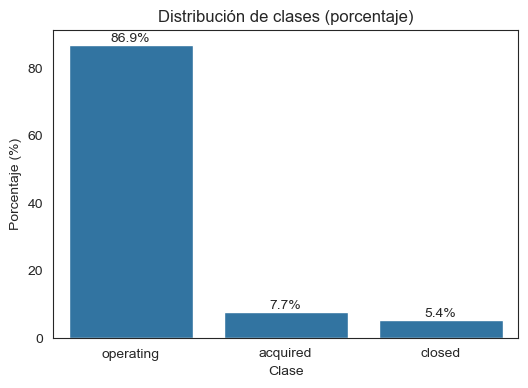

In [37]:
sns.set_style('white')
target = 'exito'


porcentajes = df[target].value_counts(normalize=True) * 100


plt.figure(figsize=(6,4))
ax = sns.barplot(x=porcentajes.index, y=porcentajes.values)
for i, v in enumerate(porcentajes.values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
ax.set_title("Distribución de clases (porcentaje)")
ax.set_xlabel("Clase")
ax.set_ylabel("Porcentaje (%)")

plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

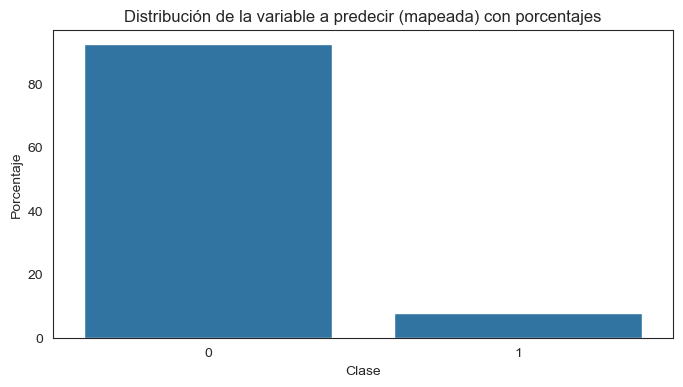

In [38]:
# target = 'exito'
# mapping = {'operating': 0, 'closed': 0, 'acquired': 1}
# df[target] = df[target].map(mapping)

# Calcular los porcentajes de cada clase en la variable 'exito'
# percentages = df[target].value_counts(normalize=True) * 100
mapping = {
    'acquired':  1,
    'closed':    0,
    'operating': 0,
    'ipo':       0
}
df['exito'] = df['exito'].map(mapping) \
                       .fillna(0) \
                       .astype(int)

# 2) Calcular porcentajes
percentages = df['exito'].value_counts(normalize=True) * 100 
# Crear el gráfico de barras con porcentajes
plt.figure(figsize=(8, 4))
sns.barplot(x=percentages.index, y=percentages.values)

# Configuración del gráfico
plt.title('Distribución de la variable a predecir (mapeada) con porcentajes')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')

plt.show

In [39]:
def year_group(row):
    if row['founded_year'] >= 1900 and row['founded_year'] <= 1925:
        row['founded_year_group'] = 'less_than_1925'
    elif row['founded_year'] > 1925 and row['founded_year'] <= 1950:
        row['founded_year_group'] = '1925_1950'
    elif row['founded_year'] > 1950 and row['founded_year'] <= 1975:
        row['founded_year_group'] = '1950_1975'
    elif row['founded_year'] > 1975 and row['founded_year'] <= 2000:
        row['founded_year_group'] = '1975_2000'
    elif row['founded_year'] > 2000:
        row['founded_year_group'] = '2000_2014'
    else:
        row['founded_year_group'] = ''
    return row['founded_year_group']

df['founded_year_group'] =  df.apply(year_group,axis =1)

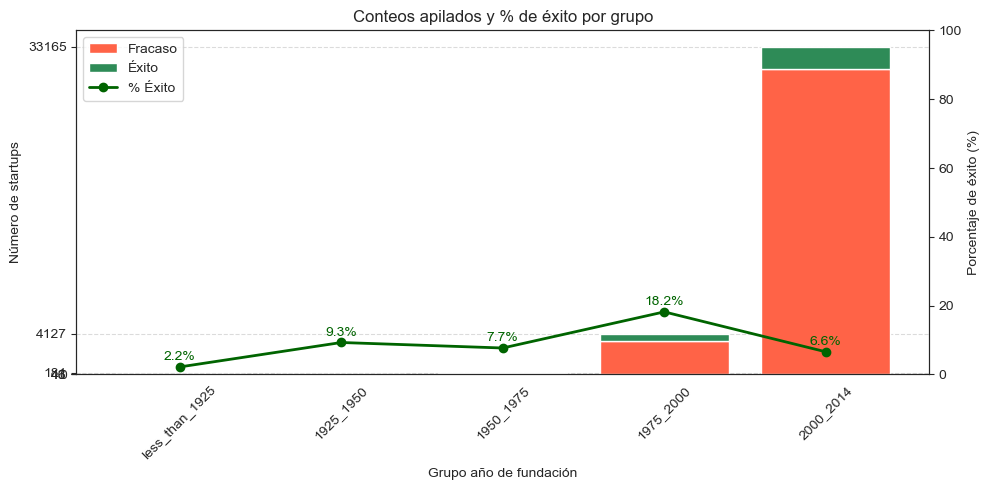

In [40]:
# 1) Preparar los datos
grouped = df.groupby('founded_year_group')['exito'].value_counts().unstack(fill_value=0)

ordered_groups = [
    'less_than_1925',
    '1925_1950',
    '1950_1975',
    '1975_2000',
    '2000_2014'
]

fails  = grouped.loc[ordered_groups, 0]
succs  = grouped.loc[ordered_groups, 1]
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)

# 2) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(10,5))

bar1 = ax1.bar(ordered_groups, fails,  label='Fracaso', color='tomato')
bar2 = ax1.bar(ordered_groups, succs, bottom=fails, label='Éxito',   color='seagreen')

# 3) Fijar los ticks del eje Y a los totales (y al 0)
yticks = np.concatenate([[0], totals.values])
ax1.set_yticks(sorted(yticks))
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Grupo año de fundación")
ax1.set_title("Conteos apilados y % de éxito por grupo")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 4) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(ordered_groups, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 5) Anotar % de éxito encima de cada punto
for x, pct in zip(ordered_groups, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 6) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()


Se puede observar que casi todas las empresas se fundan entre el año `2000` y `2014`. Por ello, ahora ploteamos la gráfica de solo los años `2000` a `2014`.

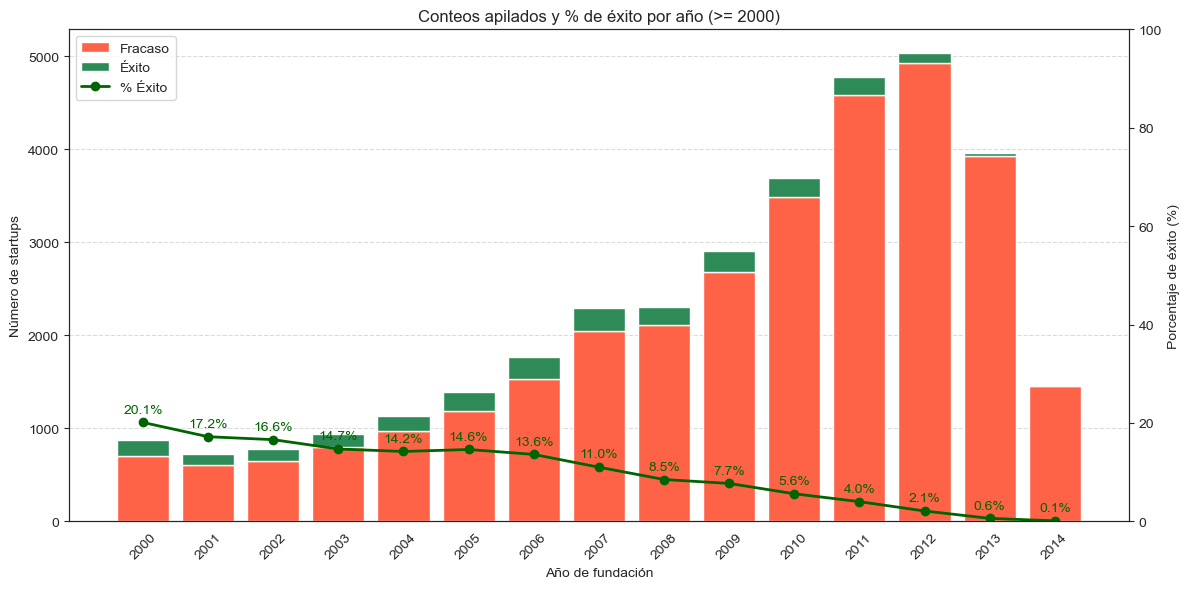

In [41]:
# 1) Filtrar los datos para años de fundación >= 2000
df_new = df[df['founded_year'] >= 2000].copy()
df_new['founded_year'] = df_new['founded_year'].astype(int)

# 2) Preparar los datos agrupados por año de fundación
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='Éxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los años
ax1.set_xticks(years)
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Año de fundación")
ax1.set_title("Conteos apilados y % de éxito por año (>= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usará los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de éxito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

Sin embargo, el intervalo de tiempo en el que las empresas tienen mayor éxito (en proporción) es entre `1975` y el año `2000`, por lo que mostramos también su gráfica.

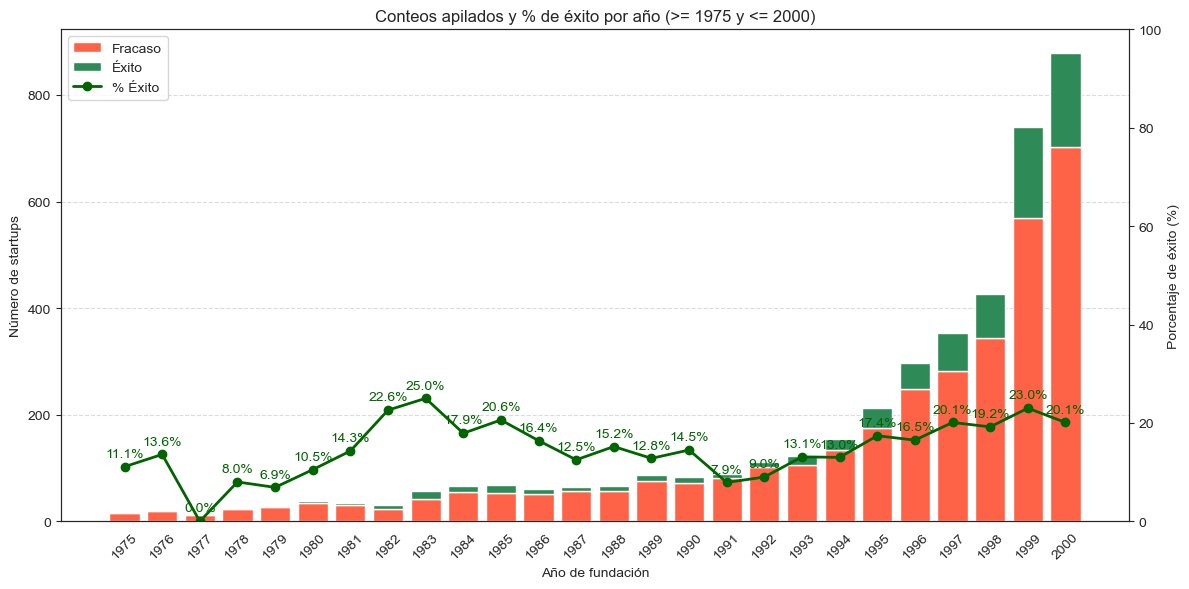

In [42]:
# 1) Filtrar los datos para años de fundación >= 2000
df_new = df[(df['founded_year'] >= 1975) & (df['founded_year'] <= 2000)].copy()
df_new['founded_year'] = df_new['founded_year'].astype(int)

# 2) Preparar los datos agrupados por año de fundación
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='Éxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los años
ax1.set_xticks(years)
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Año de fundación")
ax1.set_title("Conteos apilados y % de éxito por año (>= 1975 y <= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usará los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de éxito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

### Análisis de la intensidad de financiación

En este bloque de código vamos a explorar cómo el monto total de financiación recibido por cada startup se relaciona con su probabilidad de éxito:

1. **Limpieza y conversión**  
   - Eliminamos caracteres no numéricos (como comas) de la columna `funding_total_usd` y la convertimos a tipo numérico.  
   - Descartamos las filas donde no hay información de financiación.

2. **Discretización en intervalos**  
   - Definimos una serie de rangos (bins) que agrupan las startups según franjas de inversión (por ejemplo, `<100K`, `100K–1M`, etc.).

3. **Cálculo de éxitos y fracasos**  
   - Agrupamos el número de startups adquiridas (`exito = 1`) y no adquiridas (`exito = 0`) en cada intervalo.

4. **Visualización**  
   - Generamos un gráfico de barras **apiladas** para mostrar el conteo de éxitos y fracasos por intervalo.  
   - Sobre el mismo eje, trazamos una **línea** que indica el porcentaje de éxito dentro de cada rango de financiación.

Este análisis nos ayuda a identificar de manera intuitiva si existe algún umbral de inversión por encima del cual las startups muestran una mayor probabilidad de ser adquiridas.


C:\Users\marti\AppData\Local\Temp\ipykernel_11616\2200369026.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('fnd_bin')['exito']


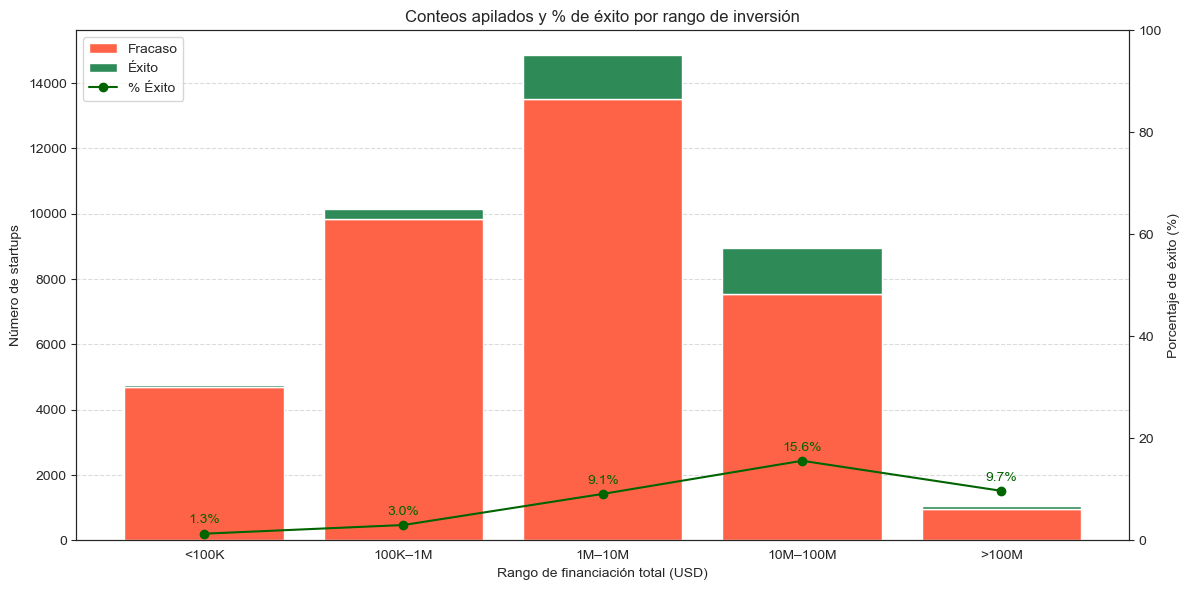

In [43]:
# 1) LIMPIEZA Y CONVERSIÓN de funding_total_usd
df['funding_total_usd'] = (
    df['funding_total_usd']
      .astype(str)
      .str.replace(',', '', regex=False)
)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df = df.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS
bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
labels = ['<100K', '100K–1M', '1M–10M', '10M–100M', '>100M']
df['fnd_bin'] = pd.cut(
    df['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR ÉXITOS/FRACASOS (**sin volver a remapear exito**)
grouped = (
    df
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(labels, fill_value=0)
)

fails = grouped[0]
succs = grouped[1]
totals = fails + succs
pct    = (succs / totals * 100).round(1).fillna(0)

# 4) PLOT Apilado + Línea de %
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(labels, fails,  color='tomato',    label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='Éxito')
ax1.set_xlabel("Rango de financiación total (USD)")
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados y % de éxito por rango de inversión")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_11616\69571450.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('fnd_bin')['exito']


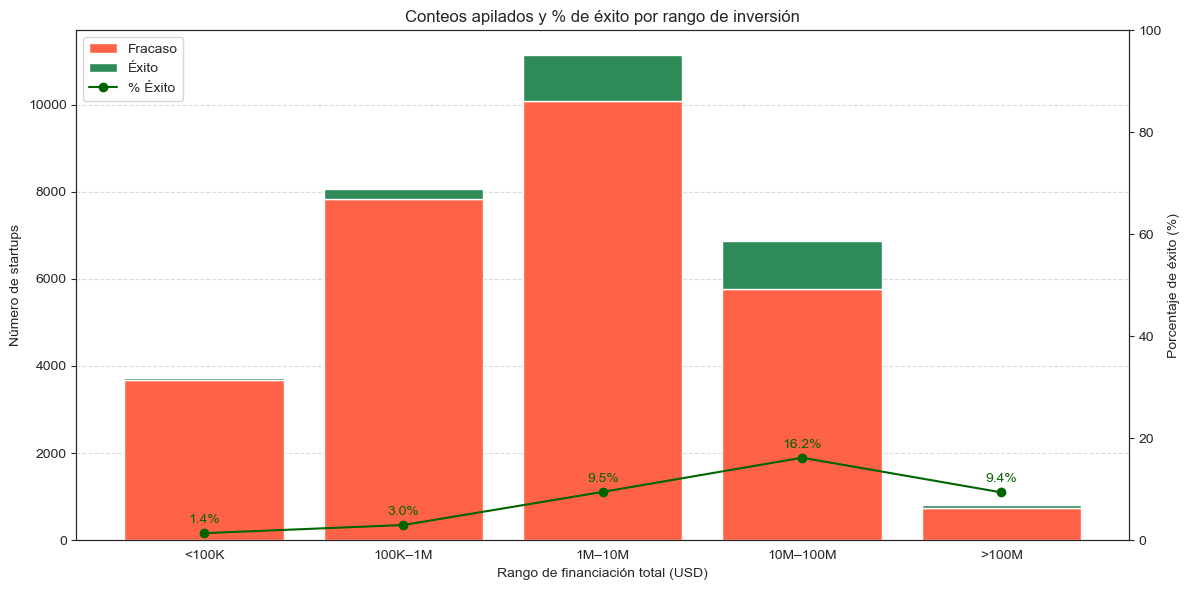

In [44]:
# Filtrar datos para incluir solo startups fundadas después de 1990
df = df[df['founded_year'] >= 1990].copy()

df = df.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS
bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
labels = ['<100K', '100K–1M', '1M–10M', '10M–100M', '>100M']

df['fnd_bin'] = pd.cut(
    df['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR ÉXITOS/FRACASOS y manejar valores ausentes
grouped = (
    df
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)  # Asegura que los valores vacíos se rellenen con 0
)

# Reindexar para asegurarse de que todos los bins estén presentes, incluso si no hay datos para alguno
grouped = grouped.reindex(labels, fill_value=0)

# Ahora obtenemos las métricas
fails = grouped[0]  # Fracasos
succs = grouped[1]  # Éxitos
totals = fails + succs  # Total de startups por bin
pct = (succs / totals * 100).round(1).fillna(0)  # Porcentaje de éxito

# 4) PLOT Apilado + Línea de %
fig, ax1 = plt.subplots(figsize=(12, 6))

# Crear gráfico apilado
ax1.bar(labels, fails, color='tomato', label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='Éxito')
ax1.set_xlabel("Rango de financiación total (USD)")
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados y % de éxito por rango de inversión")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Crear el eje para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# Añadir etiquetas de porcentaje sobre la línea
for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

# Unir las leyendas de ambos gráficos
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()


### Impacto del número de rondas de financiación

Este gráfico muestra cómo el número de rondas de financiación influye en la probabilidad de adquisición:

1. **Conteos apilados**  
   - Barras rojas (`Fracaso`): startups no adquiridas.  
   - Barras verdes (`Éxito`): startups adquiridas.  

2. **Porcentaje de éxito**  
   - Línea y marcadores en verde oscuro indican el porcentaje de startups adquiridas por cada número de rondas.  

Con este análisis podemos ver si más rondas de financiación se traducen en una mayor tasa de adquisiciones.  


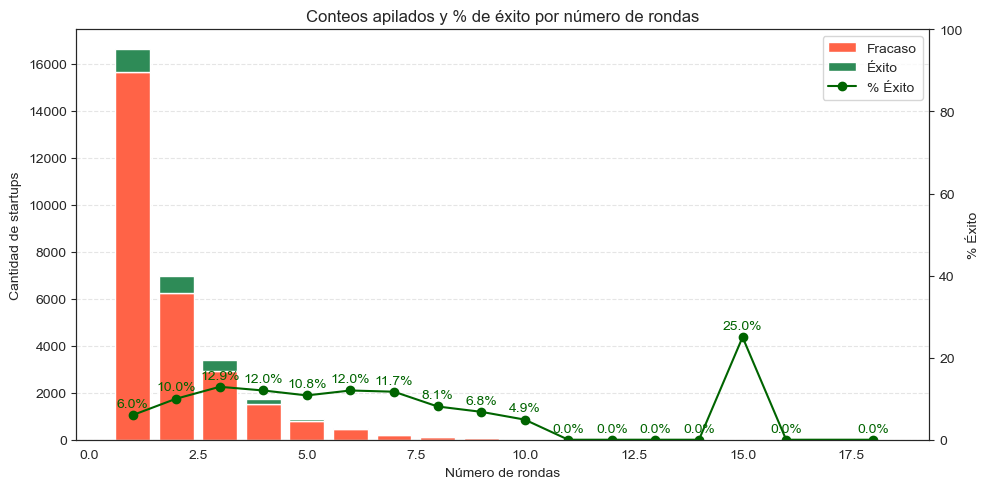

In [45]:
# 1) Agrupamos por número de rondas y exito
grp2 = (
    df.groupby('funding_rounds')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .sort_index()
)
fails2 = grp2.get(0, pd.Series(dtype=int))
succs2 = grp2.get(1, pd.Series(dtype=int))
rnds   = fails2.index
tot2   = fails2 + succs2
pct2   = (succs2 / tot2 * 100).round(1)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(rnds, fails2,  color='tomato',    label='Fracaso')
ax1.bar(rnds, succs2, bottom=fails2, color='seagreen', label='Éxito')
ax1.set_xlabel("Número de rondas")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("Conteos apilados y % de éxito por número de rondas")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(rnds, pct2, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("% Éxito")
ax2.set_ylim(0,100)

for x, p in zip(rnds, pct2):
    ax2.text(x, p+2, f"{p}%", ha='center', color='darkgreen')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()
plt.show()


### Combinación Sector–País (Top 5×Top 5)

Este gráfico muestra cómo se distribuyen las startups en los 5 sectores más frecuentes y los 5 países principales:

1. **Barras apiladas**  
   - Cada barra representa un sector.  
   - Los segmentos apilados (colores) corresponden al número de startups en cada país.  

2. **Línea de porcentaje de éxito**  
   - Línea negra con marcadores muestra el porcentaje medio de adquisiciones por sector, considerando todos los países.  

Este análisis permite ver, de un vistazo, en qué combinaciones sector–país se concentra el mayor volumen de startups y cuáles tienen la mayor tasa de éxito.  


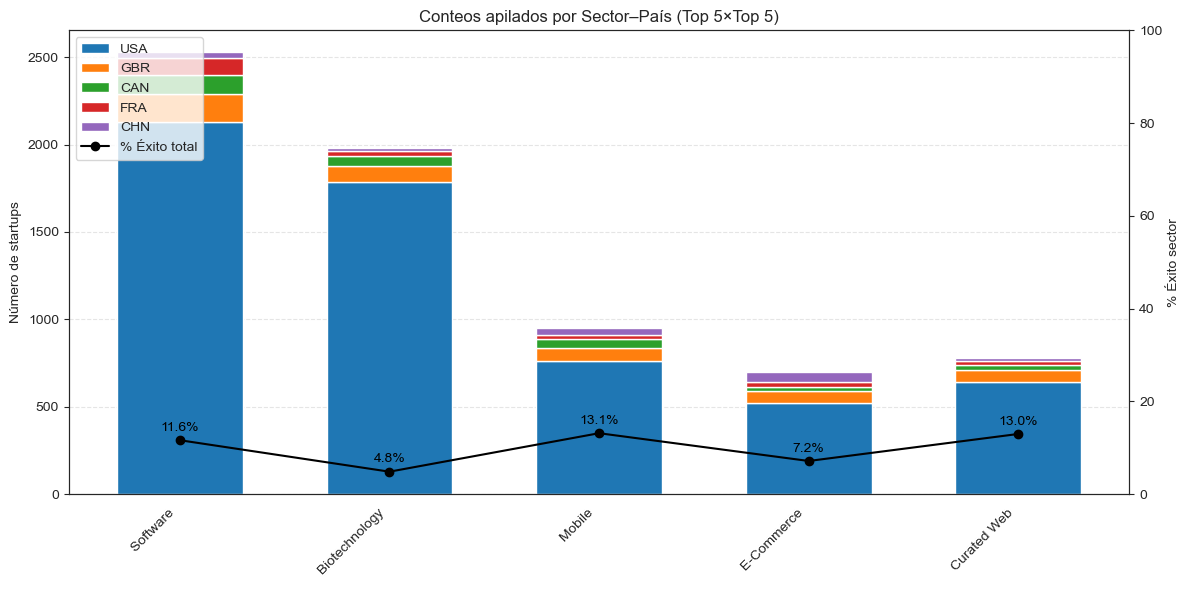

In [46]:
# 1) Filtramos top 5 de cada uno
top_secures   = df['market'].value_counts().head(5).index
top_countries = df['country_code'].value_counts().head(5).index
sub = df[df['market'].isin(top_secures) & df['country_code'].isin(top_countries)]

# 2) Pivot counts y % éxito
pivot_cnt = sub.pivot_table(
    index='market', columns='country_code', values='exito',
    aggfunc=['count','mean']
)
cnts = pivot_cnt['count']
pcts = (pivot_cnt['mean'] * 100).round(1)

# 3) Para cada sector dibujamos barras apiladas por país y % línea
fig, ax1 = plt.subplots(figsize=(12,6))
width = 0.6
x = np.arange(len(top_secures))

# apilado
bottom = np.zeros(len(top_secures))
for c in top_countries:
    vals = cnts[c].reindex(top_secures).fillna(0)
    ax1.bar(x, vals, width, bottom=bottom, label=c)
    bottom += vals

ax1.set_xticks(x)
ax1.set_xticklabels(top_secures, rotation=45, ha='right')
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados por Sector–País (Top 5×Top 5)")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# línea de % éxito promedio por sector (sobre todos los países)
avg_pct = sub.groupby('market')['exito'].mean().reindex(top_secures) * 100
ax2 = ax1.twinx()
ax2.plot(x, avg_pct, color='black', marker='o', label='% Éxito total')
ax2.set_ylabel("% Éxito sector")
ax2.set_ylim(0,100)

for xi, p in zip(x, avg_pct):
    ax2.text(xi, p+2, f"{p:.1f}%", ha='center', color='black')

# leyenda combinada
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

plt.tight_layout()
plt.show()


### Top 25 Categorías de Mercado y Éxito

Este gráfico muestra las **25 categorías más frecuentes** de startups y su **porcentaje de éxito** (startups adquiridas):

1. **Barras**: representan el porcentaje de startups por categoría.  
2. **Color secundario**: indica el porcentaje de éxito en cada una.

Permite comparar la popularidad de cada categoría con su tasa de adquisición.

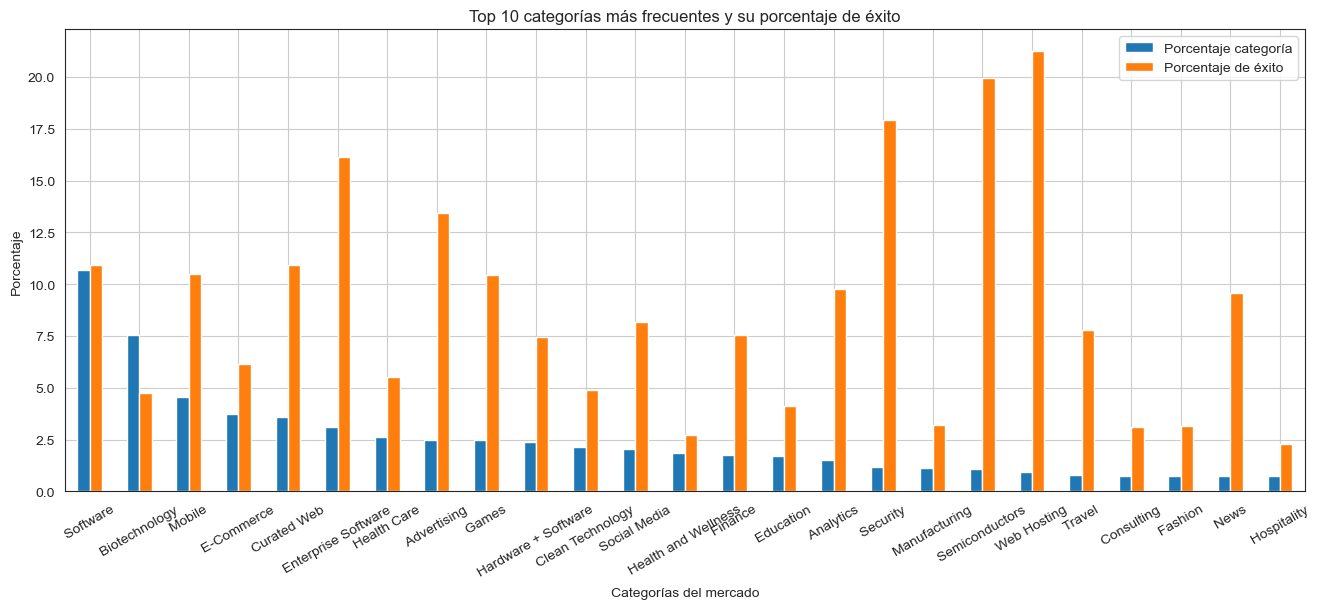

In [47]:
market_counts = df['market'].value_counts(normalize=True) * 100

# Calcular el porcentaje de 'exito = 1' para cada categoría en 'market'
success_percentage = df.groupby('market')['exito'].mean() * 100

# Crear un DataFrame con los porcentajes de las categorías y el porcentaje de éxito
result_df = pd.DataFrame({
    'Porcentaje categoría': market_counts,
    'Porcentaje de éxito': success_percentage
})

# Seleccionar las 10 categorías más frecuentes
top_categories = market_counts.head(25)

# Filtrar el DataFrame resultante para mostrar solo las categorías más frecuentes
result_df_top = result_df.loc[top_categories.index]

# Graficar
result_df_top.plot(kind='bar', figsize=(16, 6))

plt.title('Top 10 categorías más frecuentes y su porcentaje de éxito')
plt.xlabel('Categorías del mercado')
plt.ylabel('Porcentaje')
plt.xticks(rotation=30)
plt.grid()
plt.show()

Se puede observar que el número de startups **aumenta** cada año.

C:\Users\marti\AppData\Local\Temp\ipykernel_11616\641170365.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100


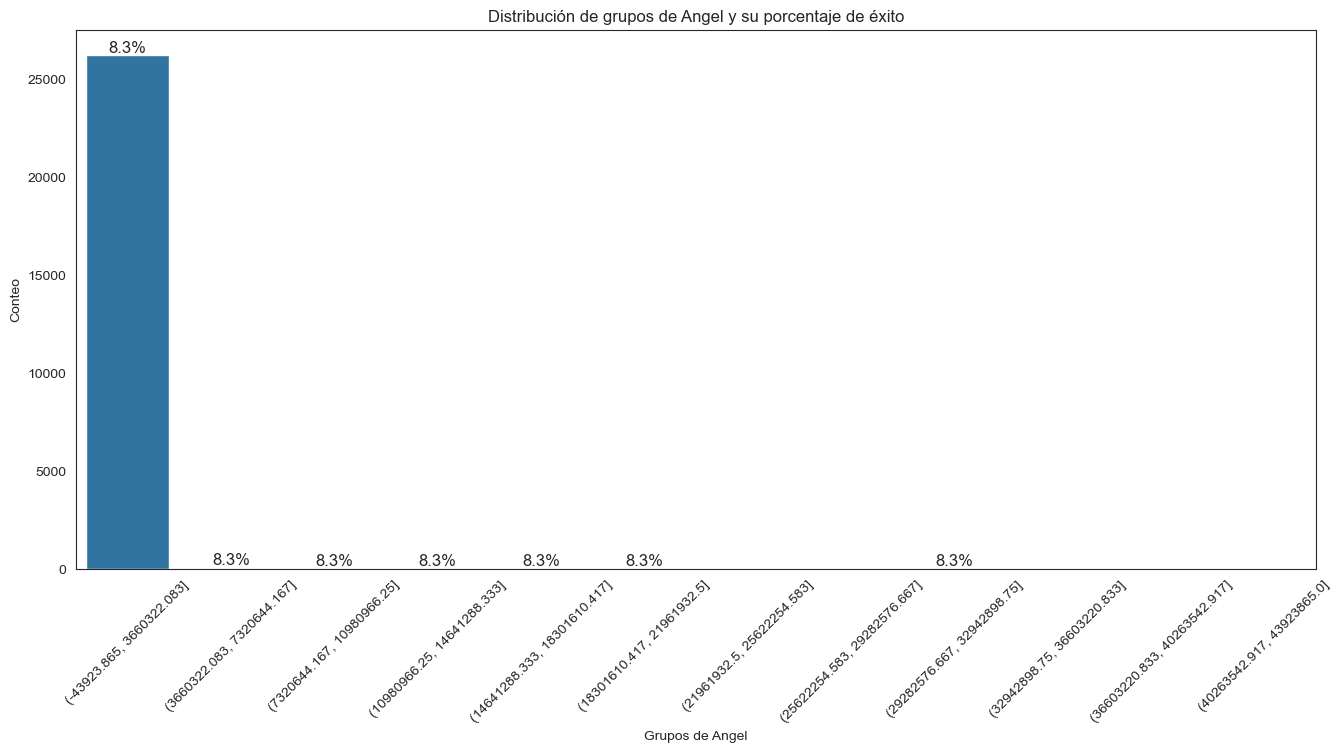

In [48]:
# Dividir la variable 'angel' en 12 grupos utilizando pd.cut
df['angel_group'] = pd.cut(df['angel'], bins=12)

# Calcular el porcentaje de 'exito = 1' para cada grupo en 'angel_group'
success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100

# Graficar la distribución de 'angel_group'
plt.figure(figsize=(16, 7))

# Gráfico de barras con el conteo de cada grupo en 'angel_group'
sns.countplot(x='angel_group', data=df.dropna())

# Añadir los porcentajes de éxito encima de las barras
for p in plt.gca().patches:
    height = p.get_height()
    # Obtener el grupo de 'angel_group' correspondiente
    group_label = p.get_x() + p.get_width() / 2
    group_label = df['angel_group'].iloc[int(group_label)]  # Identificar la categoría por índice
    
    # Añadir el texto con el porcentaje de éxito en el gráfico
    plt.text(p.get_x() + p.get_width() / 2, height + 1, f'{success_percentage_angel_group[group_label]:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribución de grupos de Angel y su porcentaje de éxito')
plt.xlabel('Grupos de Angel')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()


Podemos observar que casi todas las startups son de `Software` y `Biotechnology`, seguidas de `Mobile`,`E-Commerce` y `Curated Webs`.

Realizamos un análisis de la variable a predecir en este caso, exito.

De momento vamos a asignar, la clase 1 a acquired y 0 a closed. Pero podríamos realizar otra distribución de clases si fuera de interés para el trabajo

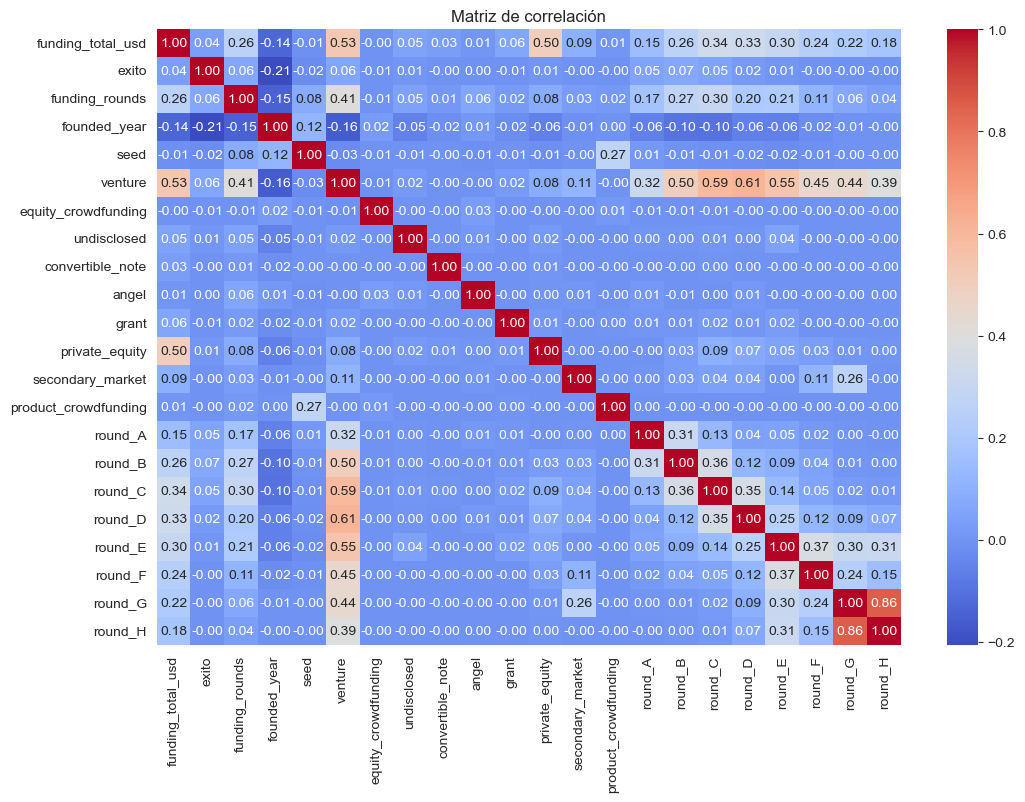

In [49]:
# Creamos una matriz de correlación entre las variables numéricas
numerical_df = df.select_dtypes(include=['number']) 
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

Text(0.5, 1.0, 'Relación entre funding_rounds, founded_year y exito')

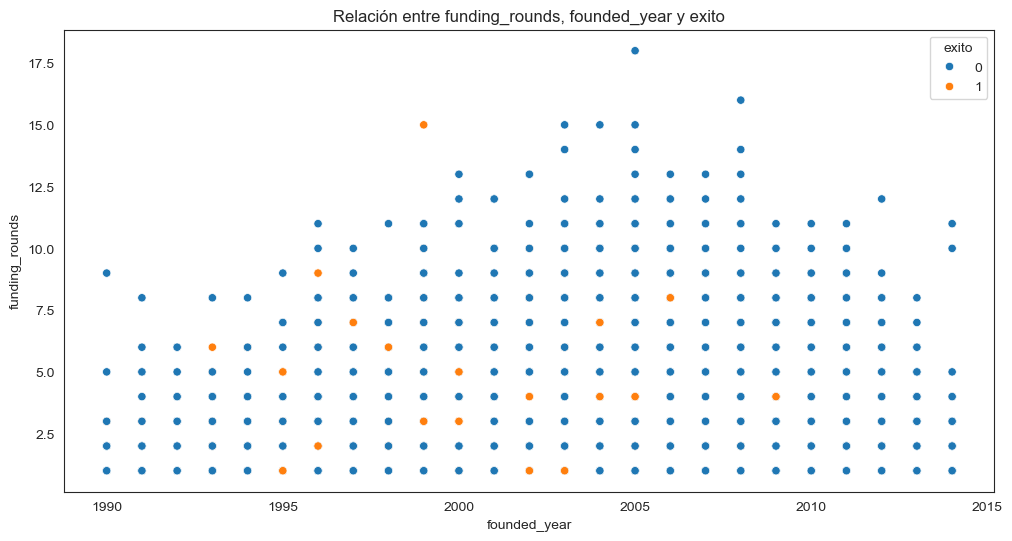

In [50]:
# Observamos que variables que están más correlacionadas con la variable de salida son funding_round y founded_year
# Observamos relacion entre funding_round, founded_year y variable objetivo 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='founded_year', y='funding_rounds', hue='exito')
plt.title('Relación entre funding_rounds, founded_year y exito')

Más rondas de financiación aumentan la probabilidad de salida: Las startups con más rondas de financiación (4 o más) tienen mayor probabilidad de ser "adquiridas" o "cerradas" en comparación con aquellas con menos rondas (1-3), que suelen estar "operando". Esto sugiere que una financiación sostenida aumenta las posibilidades de un evento de salida.

C:\Users\marti\AppData\Local\Temp\ipykernel_11616\3909155556.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)


<Figure size 1000x600 with 0 Axes>

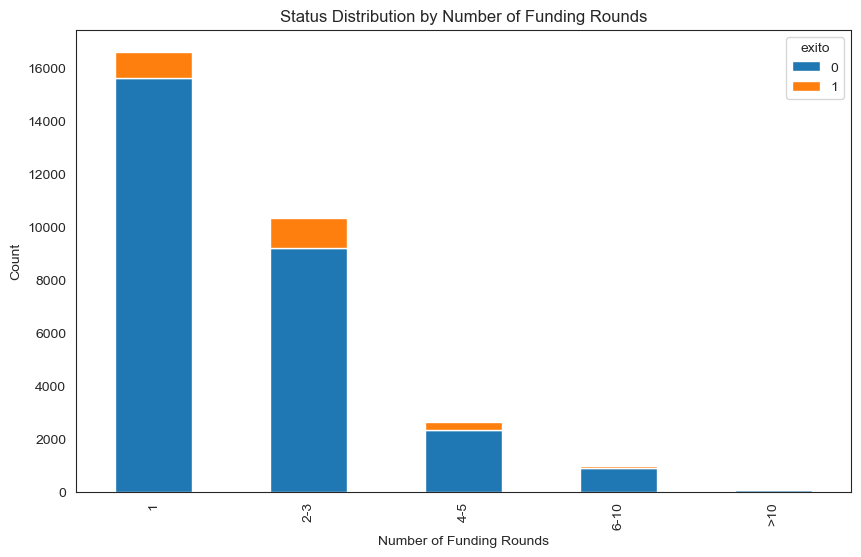

In [51]:
# Relationship 1: More Funding Rounds Increase Exit Likelihood
plt.figure(figsize=(10, 6))
df['funding_rounds_bin'] = pd.cut(df['funding_rounds'], bins=[0, 1, 3, 5, 10, float('inf')],
                                 labels=['1', '2-3', '4-5', '6-10', '>10'])
status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)
status_rounds.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Status Distribution by Number of Funding Rounds')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Count')
plt.legend(title='exito')
plt.show()


Mayores cantidades de financiación se correlacionan con adquisiciones: Las startups adquiridas tienen una mediana de financiación más alta ($10M) en comparación con las cerradas y las que están operando ($1M), lo que indica que más financiación aumenta la probabilidad de adquisición, mientras que menos financiación puede llevar al cierre.

<Figure size 1000x600 with 0 Axes>

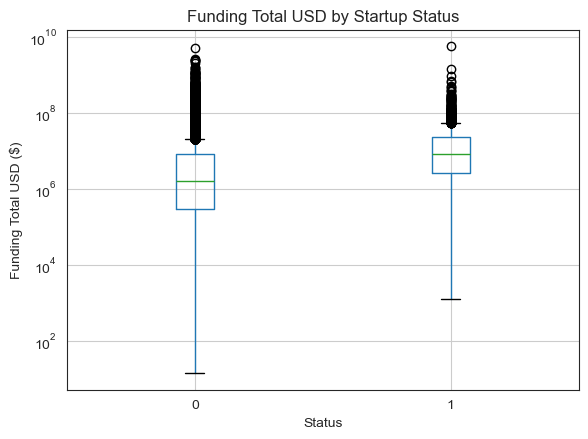

In [52]:
# Relationship 2: Higher Funding Amounts Correlate with Acquisitions
plt.figure(figsize=(10, 6))
df.boxplot(column='funding_total_usd', by='exito', showfliers=True)
plt.title('Funding Total USD by Startup Status')
plt.suptitle('')
plt.xlabel('Status')
plt.ylabel('Funding Total USD ($)')
plt.yscale('log')
plt.show()


La edad de la startup afecta su estado: Las startups más nuevas (post-2010) están mayormente "operando", mientras que las más antiguas (pre-2005) tienen más estados "adquiridas" y "cerradas". El período 2005-2010 muestra una mezcla equilibrada, sugiriendo que 5-15 años tras la fundación es un período crítico para salidas.


# Relationship 3: Startup Age Affects Status


Tendencias de financiación a lo largo del tiempo: La financiación total alcanzó su pico alrededor de 2010-2015, reflejando un auge en la inversión en startups, mientras que el número promedio de rondas de financiación por startup se mantiene estable (1-2.5). Nota: Las tendencias antes de 1980 fueron excluidas debido a problemas de calidad de datos.

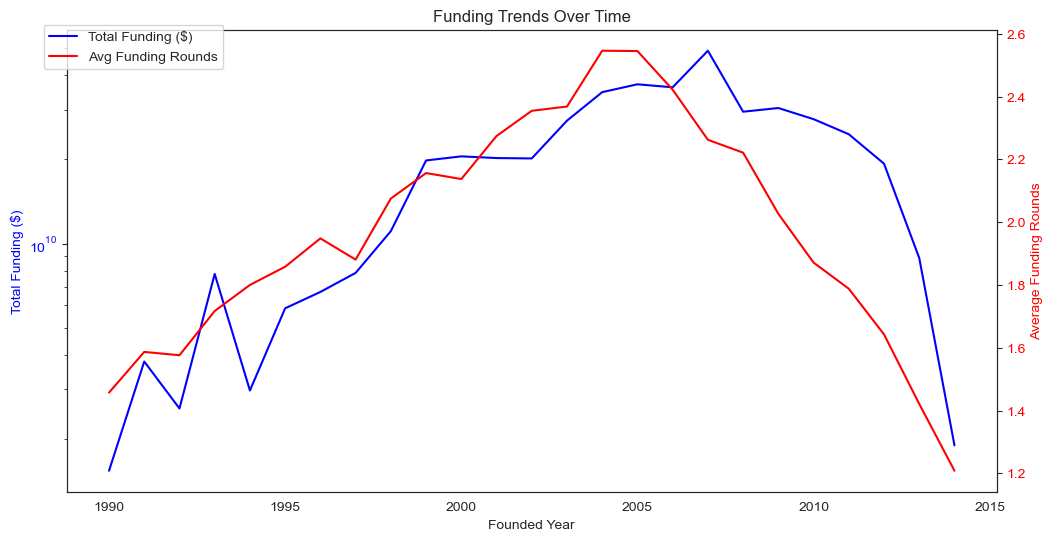

In [53]:

# Relationship 5: Funding Trends Over Time
df_yearly = df.groupby('founded_year').agg({
    'funding_total_usd': 'sum',
    'funding_rounds': 'mean'
}).reset_index()
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_yearly['founded_year'], df_yearly['funding_total_usd'], 'b-', label='Total Funding ($)')
ax1.set_xlabel('Founded Year')
ax1.set_ylabel('Total Funding ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.plot(df_yearly['founded_year'], df_yearly['funding_rounds'], 'r-', label='Avg Funding Rounds')
ax2.set_ylabel('Average Funding Rounds', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Funding Trends Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 4. Preparación de los datos para clasificación simple
Para poder realizar predicciones al principio, tenemos que lidiar con valores nulos primero realizaremos un analisis sencillo y los ignoraremos o sustituiremos, posteriormente usaremos tecnicas de imputacion y similares para intentar no perder informacion relevante.

Posteriormente aplicaremos una pipeline sencilla con knn para una primera clasificacion simple del problema

In [54]:
# Creamos pipeline para eliminar valores nulos y transformar variables categóricas con knn, evaluamos modelo con la funcion evaluar_modelo
#hacer train_test_split -> 30% para test 

# Ensure 'exito' column exists and is correctly named
if 'exito' not in df.columns:
    raise KeyError("The column 'exito' is not found in the DataFrame. Check the column names.")

# Separar columnas numéricas y categóricas, excluyendo la columna objetivo 'exito'
numerical_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['exito'], errors='ignore').columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Crear transformadores para columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Crear pipeline completa
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn_neighbors())
])

# Convertir X y y manteniendo X como DataFrame para compatibilidad con ColumnTransformer
X = df.drop(columns=['exito'], errors='ignore')
y = df['exito'].astype(float)  # Asegurarse de que y sea numérico

# Evaluar el pipeline
evaluar_pipeline(X, y.to_numpy(), pipeline, beta=1)

{'f_beta': np.float64(0.06802721088435375),
 'AUC-PR': np.float64(0.15070537848023685)}

### Limpiar data

Primero eliminamos las variables que sean creado para poder visualizar las gráficas.

In [ ]:
# # Lista de las columnas de EDA que quieres eliminar
# cols_to_drop = [
#     'founded_year_group',
#     'fnd_bin',
#     'angel_group',
#     'funding_rounds_bin'
# ]

# # Opción A: borrarlas directamente del df original
# df.drop(columns=cols_to_drop, inplace=True)

## 5. Imputación de valores perdidos

#### 5.1 Validación

In [57]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X = df.drop(columns=['exito']).copy()
y = df['exito']

# División inicial: 60% entrenamiento, 40% restante
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# División secundaria: 50% validación, 50% prueba del 40% restante
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Tamaños de los conjuntos: \nEntrenamiento: {X_train.shape}, Validación: {X_val.shape}, Prueba: {X_test.shape}")

Tamaños de los conjuntos: 
Entrenamiento: (18380, 32), Validación: (6127, 32), Prueba: (6127, 32)


In [58]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, precision_recall_curve, auc
import pandas as pd
import numpy as np

# 2) Define las columnas
numerical_cols   = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# 3) Imputadores personalizados
def impute_with_sampling_df(X):
    X = pd.DataFrame(X, columns=numerical_cols)
    for col in X.columns:
        vals = X[col].dropna().values
        if len(vals) > 0:
            mask = X[col].isna()
            X.loc[mask, col] = np.random.choice(vals, size=mask.sum(), replace=True)
    return X

numeric_imputers = {
    'sampling': FunctionTransformer(impute_with_sampling_df, validate=False),
    'mean':     SimpleImputer(strategy='mean'),
    'median':   SimpleImputer(strategy='median'),
}
categorical_imputers = {
    'mode': Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='ignore'))
    ]),
    'constant': Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', OneHotEncoder(handle_unknown='ignore'))
    ]),
}

# 4) Usa las mejores combinaciones obtenidas anteriormente
best_numeric_imp = 'sampling'  # ← sustituye por el valor que te dio mejor resultado
best_categorical_imp = 'mode'  # ← idem

num_imp = numeric_imputers[best_numeric_imp]
cat_pipe = categorical_imputers[best_categorical_imp]

preprocessor = ColumnTransformer([
    ('num', num_imp, numerical_cols),
    ('cat', cat_pipe, categorical_cols),
], remainder='drop')

# 5) Construye y evalúa el pipeline final
pipeline_final = Pipeline([
    ('pre', preprocessor),
    ('clf', KNeighborsClassifier())
])
pipeline_final.fit(X_train, y_train)
y_pred = pipeline_final.predict(X_val)
y_proba = pipeline_final.predict_proba(X_val)[:, 1]

f0_7 = fbeta_score(y_val, y_pred, beta=0.7)
precision, recall, _ = precision_recall_curve(y_val, y_proba)
auc_pr = auc(recall, precision)

print(f"F₀.₇ final: {f0_7:.4f}")
print(f"AUC-PR final: {auc_pr:.4f}")


F₀.₇ final: 0.0931
AUC-PR final: 0.1503


## 6. Transformación del tipo de variable

En primer lugar, antes de estandarizar los datos, nos tenemos que asegurar de que están en su tipo correcto. Es por ello, por lo que primero hay que:
1. Transformar los tipos de datos que consideremos.
2. Imputar los valores perdidos

In [59]:
# Sobreescribe la original con el año entero
df['founded_year'] = df['founded_year'].dt.year

# Ahora aplica pd.cut en línea sobre esa columna
df['founded_year'] = pd.cut(
    df['founded_year'],
    bins=[1900, 1925, 1950, 1975, 2000, 2015],
    labels=['1900–25','25–50','50–75','75–00','00–14'],
    include_lowest=True
)
df['founded_year'] = df['founded_year'].cat.codes.replace(-1, np.nan)


#### 6.1 Validación

In [60]:
# 1) Quita 'founded_year' de numerical_cols (ya lo hiciste)
num_cols = [c for c in numerical_cols if c != 'founded_year']

# 2) Reconstruye el preprocesador usando 'founded_year_int'
preprocessor = ColumnTransformer([
    ('num',          num_imp,           num_cols),
    ('cat',          cat_pipe,          categorical_cols),
], remainder='drop')

# 3. El resto igual
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', KNeighborsClassifier())
])

# 4. Evaluar
scores = evaluar_pipeline(X, y, pipe, beta=0.7, test_size=0.2, random_state=42)
print(f"F₀.₇ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")


F₀.₇ = 0.1151, AUC-PR = 0.1486


### Discretización de la variable `homepage_url`

La variable `homepage_url` indica si una startup tiene o no una página web registrada. Aunque su contenido es textual, su presencia puede reflejar cierto grado de profesionalización o visibilidad que favorece el éxito de la start-up.

**Transformación aplicada**:  
Se ha convertido en una variable binaria (`has_url`), con valor `1` si la URL está presente y `0` en caso contrario.

Esta transformación permite incluir esta información como una característica útil en los modelos de clasificación.


In [61]:
df.head(10)

,homepage_url,category_list,market,funding_total_usd,exito,country_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,1,USA,New York City,New York,1.0,2012-06-01,2012-06-01,2012-Q2,4,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,0,EST,Tallinn,Tallinn,1.0,2012-10-26,2012-10-01,2012-Q4,4,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,0,GBR,London,London,1.0,2011-04-01,2011-04-01,2011-Q2,4,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,0,USA,Dallas,Fort Worth,2.0,2014-01-01,2014-01-01,2014-Q1,4,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,http://www.0-6.com,|Curated Web|,Curated Web,2000000.0,0,NaN,NaN,NaN,1.0,2007-01-01,2007-01-01,2007-Q1,4,2008-03-19,2008-03-19,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,http://www.123listo.com,|E-Commerce|,E-Commerce,40000.0,0,CHL,Santiago,Las Condes,1.0,2012-01-01,2012-01-01,2012-Q1,4,2013-02-18,2013-02-18,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,http://10minuteswith.com,|Education|,Education,4400000.0,0,GBR,London,London,2.0,2013-01-01,2013-01-01,2013-Q1,4,2013-01-01,2014-10-09,400000.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,http://www.10-20media.com,|E-Commerce|,E-Commerce,2050000.0,0,USA,Baltimore,Woodbine,4.0,2001-01-01,2001-01-01,2001-Q1,4,2009-06-18,2011-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,http://1000corks.com,|Search|,Search,40000.0,0,USA,"Portland, Oregon",Lake Oswego,1.0,2008-01-01,2008-01-01,2008-Q1,4,2011-08-23,2011-08-23,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,http://www.1000markets.com,|Marketplaces|Art|E-Commerce|,Marketplaces,500000.0,1,NaN,NaN,NaN,1.0,2009-01-01,2009-01-01,2009-Q1,4,2009-05-15,2009-05-15,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Crear variable binaria: 1 si tiene homepage_url, 0 si está vacía o es NaN
df['homepage_url'] = df['homepage_url'].notna().astype(int)

#### 6.2 Validación

In [63]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

# 0) Definir los distintos encoders que vas a probar
categorical_encoders = {
    'onehot':  OneHotEncoder(handle_unknown='ignore', sparse_output=False),
    'ordinal': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'target':  TargetEncoder()
}

results = []
for enc_name, encoder in categorical_encoders.items():
    print(f"\n--- Evaluating {enc_name} encoder with has_url ---")

    # Build the preprocessing+classifier pipeline
    num_imp = numeric_imputers[best_numeric_imp]
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', encoder)
    ])
    preprocessor = ColumnTransformer([
        ('num', num_imp, numerical_cols),        # Ahora incluye 'has_url'
        ('cat', cat_pipe, categorical_cols)
    ], remainder='drop')

    pipe = Pipeline([
        ('pre', preprocessor),
        ('clf', KNeighborsClassifier())
    ])

    scores = evaluar_pipeline(X_val, y_val, pipe, beta=0.7, test_size=0.2, random_state=42)
    print(f"{enc_name:7s} → f₁ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")

    results.append({
        'encoding': enc_name,
        'f_beta':   scores['f_beta'],
        'AUC-PR':   scores['AUC-PR'],
        'error':    None
    })

# Summarize again
encoding_results = pd.DataFrame(results).sort_values(['f_beta', 'AUC-PR'], ascending=False)
display(encoding_results)



--- Evaluating onehot encoder with has_url ---
onehot  → f₁ = 0.0688, AUC-PR = 0.1113

--- Evaluating ordinal encoder with has_url ---
ordinal → f₁ = 0.0903, AUC-PR = 0.1170

--- Evaluating target encoder with has_url ---
target  → f₁ = 0.0688, AUC-PR = 0.1094


,encoding,f_beta,AUC-PR,error
1,ordinal,0.09033,0.116990,None
0,onehot,0.06879,0.111294,None
2,target,0.06879,0.109357,None


A continuación visualizamos de manera gráfica discretizada:

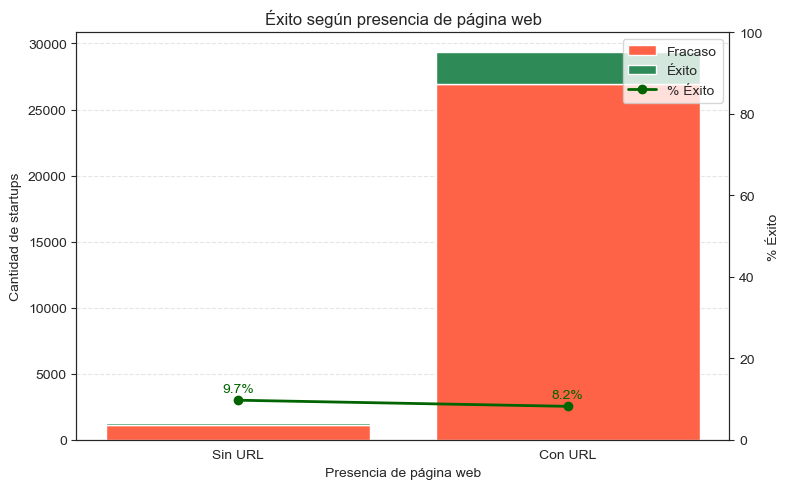

In [64]:
# 1) Agrupar por presencia de URL (0 = sin URL, 1 = con URL)
grp = (
    df.groupby('homepage_url')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .sort_index()
)

fails = grp.get(0, pd.Series(dtype=int))
succs = grp.get(1, pd.Series(dtype=int))
labels = ['Sin URL', 'Con URL']
totals = fails + succs
pct_success = (succs / totals * 100).round(1)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(labels, fails, color='tomato', label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='Éxito')
ax1.set_xlabel("Presencia de página web")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("Éxito según presencia de página web")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# 3) Eje secundario con porcentaje
ax2 = ax1.twinx()
ax2.plot(labels, pct_success, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("% Éxito")
ax2.set_ylim(0, 100)

# 4) Añadir texto con porcentaje
for x, pct in zip(labels, pct_success):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 5) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

plt.tight_layout()
plt.show()

### Éxito según presencia de página web

El resultado puede parecer contraintuitivo: las startups **sin URL tienen un porcentaje de éxito (9.7%) ligeramente mayor** que aquellas con URL (8.2%). Esto puede deberse a varios factores:

- Algunas startups **más antiguas o corporativas** pudieron ser adquiridas sin necesidad de tener una página web pública.
- Puede haber un **sesgo de representación**, ya que las startups con URL son muchas más (como muestra la gráfica) y muchas de ellas pueden seguir operativas, sin haber sido aún adquiridas.

Entonces lo que se nos puede ocurrir es si puede combinar con alguna otra variable para ver si aumenta esta diferencia. Por ejemplo, ¿Las startups sin URL tienen mayor éxito solo porque son más antiguas? (ponemos que sean mayores de 1975, dado que antes es muy improbable sino imposible que tuvieran dominio web).

C:\Users\marti\AppData\Local\Temp\ipykernel_11616\4288222601.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df_web.groupby(['founded_year_group', 'homepage_url'])['exito'].value_counts().unstack(fill_value=0)


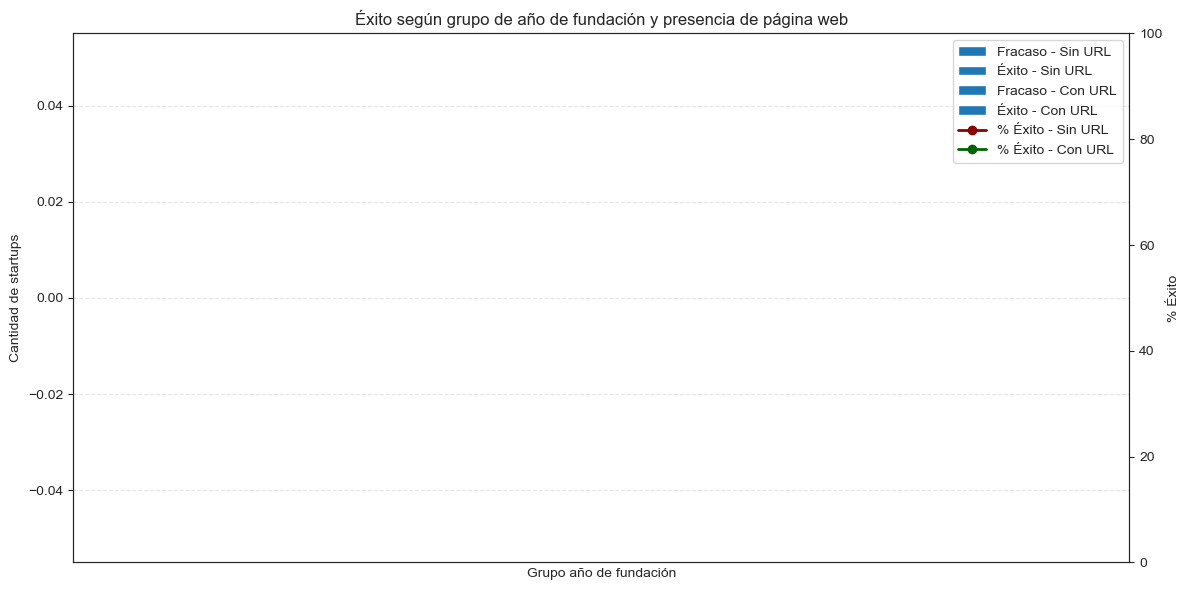

In [65]:
# 1) Filtrar y agrupar
df_web = df[df['founded_year'] > 1975].copy()

df_web['founded_year_group'] = pd.cut(
    df_web['founded_year'],
    bins=[1975, 1990, 2000, 2005, 2010, 2015],
    labels=['75–90', '90–00', '00–05', '05–10', '10–15']
)

# 2) Agrupamos por grupo y presencia de URL
grp = df_web.groupby(['founded_year_group', 'homepage_url'])['exito'].value_counts().unstack(fill_value=0)

# 3) Extraemos datos por grupo
results = []
for year_group in grp.index.levels[0]:
    try:
        # Fracaso y éxito con y sin URL
        f0 = grp.loc[(year_group, 0)][0] if (year_group, 0) in grp.index else 0
        s0 = grp.loc[(year_group, 0)][1] if (year_group, 0) in grp.index else 0
        f1 = grp.loc[(year_group, 1)][0] if (year_group, 1) in grp.index else 0
        s1 = grp.loc[(year_group, 1)][1] if (year_group, 1) in grp.index else 0
        results.append((str(year_group), f0, s0, f1, s1))
    except:
        continue

# 4) Datos
labels = [r[0] for r in results]
f0s = [r[1] for r in results]
s0s = [r[2] for r in results]
f1s = [r[3] for r in results]
s1s = [r[4] for r in results]

total0 = np.array(f0s) + np.array(s0s)
total1 = np.array(f1s) + np.array(s1s)
pct0 = np.divide(s0s, total0, out=np.zeros_like(s0s, dtype=float), where=total0!=0) * 100
pct1 = np.divide(s1s, total1, out=np.zeros_like(s1s, dtype=float), where=total1!=0) * 100

# 5) Plot
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras
ax1.bar(x - width/2, f0s, width, color='tomato', label='Fracaso - Sin URL')
ax1.bar(x - width/2, s0s, width, bottom=f0s, color='seagreen', label='Éxito - Sin URL')

ax1.bar(x + width/2, f1s, width, color='lightsalmon', label='Fracaso - Con URL')
ax1.bar(x + width/2, s1s, width, bottom=f1s, color='mediumseagreen', label='Éxito - Con URL')

ax1.set_xlabel("Grupo año de fundación")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("Éxito según grupo de año de fundación y presencia de página web")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Línea de % éxito
ax2 = ax1.twinx()
ax2.plot(x - width/2, pct0, color='darkred', marker='o', linewidth=2, label='% Éxito - Sin URL')
ax2.plot(x + width/2, pct1, color='darkgreen', marker='o', linewidth=2, label='% Éxito - Con URL')
ax2.set_ylabel("% Éxito")
ax2.set_ylim(0, 100)

for xi, p in zip(x - width/2, pct0):
    ax2.text(xi, p + 2, f"{p:.1f}%", ha='center', color='darkred')
for xi, p in zip(x + width/2, pct1):
    ax2.text(xi, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

# Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

plt.tight_layout()
plt.show()


Se puede observar que conforme avanzan los años, tener una página web ha de relacionarse con el éxito de un start-up.

### Transformación de la columna `market` de categórico a numérico
Usaremos codificación de conteo, dado que no usamos así la variable objetivo `éxito` y evitamos el over-fitting.

In [66]:
# 1 — calcular la frecuencia de cada categoría
market_freq = df['market'].value_counts()

# 2 — reemplazar la columna por su frecuencia
df['market'] = df['market'].map(market_freq)

# 3 — si hubiera categorías nuevas en test (NaN), les damos frecuencia 1
df['market'] = df['market'].fillna(1)

In [67]:
df.head(10)

,homepage_url,category_list,market,funding_total_usd,exito,country_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,1,|Entertainment|Politics|Social Media|News|,219.0,1750000.0,1,USA,New York City,New York,1.0,2012-06-01,2012-06-01,2012-Q2,4,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,|Publishing|Education|,49.0,40000.0,0,EST,Tallinn,Tallinn,1.0,2012-10-26,2012-10-01,2012-Q4,4,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,|Electronics|Guides|Coffee|Restaurants|Music|i...,21.0,1500000.0,0,GBR,London,London,1.0,2011-04-01,2011-04-01,2011-Q2,4,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,|Tourism|Entertainment|Games|,17.0,60000.0,0,USA,Dallas,Fort Worth,2.0,2014-01-01,2014-01-01,2014-Q1,4,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,|Curated Web|,1072.0,2000000.0,0,NaN,NaN,NaN,1.0,2007-01-01,2007-01-01,2007-Q1,4,2008-03-19,2008-03-19,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1,|E-Commerce|,1106.0,40000.0,0,CHL,Santiago,Las Condes,1.0,2012-01-01,2012-01-01,2012-Q1,4,2013-02-18,2013-02-18,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1,|Education|,511.0,4400000.0,0,GBR,London,London,2.0,2013-01-01,2013-01-01,2013-Q1,4,2013-01-01,2014-10-09,400000.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1,|E-Commerce|,1106.0,2050000.0,0,USA,Baltimore,Woodbine,4.0,2001-01-01,2001-01-01,2001-Q1,4,2009-06-18,2011-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1,|Search|,193.0,40000.0,0,USA,"Portland, Oregon",Lake Oswego,1.0,2008-01-01,2008-01-01,2008-Q1,4,2011-08-23,2011-08-23,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1,|Marketplaces|Art|E-Commerce|,158.0,500000.0,1,NaN,NaN,NaN,1.0,2009-01-01,2009-01-01,2009-Q1,4,2009-05-15,2009-05-15,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 6.3 Validación

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from types import SimpleNamespace
# 1) Ya has hecho count‐encoding y binning antes del split:
#    df['market'], df['cat_bin'], df['has_url']

# 2) Split
X = df.drop(columns=['exito'])
y = df['exito']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 3) Recalcular listas
numerical_cols   = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Numéricas:", numerical_cols)
print("Categóricas:", categorical_cols)

# 4) Pipeline sólo con el mejor encoder (target):
best_row = encoding_results.iloc[0]
best_enc = best_row['encoding']
best      = SimpleNamespace(**best_row.to_dict())

encoder = categorical_encoders[best_enc]

num_imp = numeric_imputers[best_numeric_imp]
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enc', encoder)
])
preprocessor = ColumnTransformer([
    ('num', num_imp, numerical_cols),
    ('cat', cat_pipe, categorical_cols),
], remainder='drop')

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', KNeighborsClassifier())
])

# 5) Evaluación
scores = evaluar_pipeline(
    X_val, y_val, pipe,
    beta=0.7, test_size=0.2, random_state=42
)
print(f"Con codificador `{best_enc}` → F₀.₇ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")


Numéricas: ['homepage_url', 'market', 'funding_total_usd', 'funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'angel', 'grant', 'private_equity', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']
Categóricas: ['category_list', 'country_code', 'region', 'city', 'founded_quarter']
Con codificador `ordinal` → F₀.₇ = 0.0799, AUC-PR = 0.1432


## 7. Deteccion de outliers

In [69]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=3.0):
        self.factor = factor
        self.bounds_ = {}

    def fit(self, X, y=None):
        # Make sure X is a DataFrame
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Calculate bounds for each column
        for col_name in X_df.columns:
            col = X_df[col_name].astype(float)
            Q1, Q3 = np.nanpercentile(col, [25, 75])
            IQR = Q3 - Q1
            self.bounds_[col_name] = (Q1 - self.factor * IQR, Q3 + self.factor * IQR)
        return self

    def transform(self, X):
        # Make sure X is a DataFrame and create a copy
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        X_out = X_df.copy()
        
        # Apply bounds to each column
        for col_name, (low, high) in self.bounds_.items():
            if col_name in X_out.columns:
                X_out[col_name] = np.clip(X_out[col_name], low, high)
        return X_out

class ZScoreClipper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3.0):
        self.threshold = threshold
        self.means_ = {}
        self.stds_ = {}

    def fit(self, X, y=None):
        # Make sure X is a DataFrame
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Calculate mean and std for each column
        for col_name in X_df.columns:
            col = X_df[col_name].astype(float)
            self.means_[col_name] = np.nanmean(col)
            self.stds_[col_name] = np.nanstd(col)
        return self

    def transform(self, X):
        # Make sure X is a DataFrame and create a copy
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        X_out = X_df.copy()
        
        # Apply z-score clipping to each column
        for col_name in X_out.columns:
            if col_name in self.means_:
                mean = self.means_[col_name]
                std = self.stds_[col_name]
                if std > 0:  # Avoid division by zero
                    lower = mean - self.threshold * std
                    upper = mean + self.threshold * std
                    X_out[col_name] = np.clip(X_out[col_name], lower, upper)
        return X_out

class PercentileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=1, upper_percentile=99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds_ = {}

    def fit(self, X, y=None):
        # Make sure X is a DataFrame
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        
        # Calculate percentile bounds for each column
        for col_name in X_df.columns:
            col = X_df[col_name].astype(float)
            low = np.nanpercentile(col, self.lower_percentile)
            high = np.nanpercentile(col, self.upper_percentile)
            self.bounds_[col_name] = (low, high)
        return self

    def transform(self, X):
        # Make sure X is a DataFrame and create a copy
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        X_out = X_df.copy()
        
        # Apply percentile bounds to each column
        for col_name, (low, high) in self.bounds_.items():
            if col_name in X_out.columns:
                X_out[col_name] = np.clip(X_out[col_name], low, high)
        return X_out

class NoClipper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.copy()
    

# Create dictionary of outlier methods
outlier_methods = {
    'iqr_1.5': OutlierClipper(factor=1.5),
    'iqr_3.0': OutlierClipper(factor=3.0),
    'iqr_5.0': OutlierClipper(factor=5.0),
    'zscore_2': ZScoreClipper(threshold=2.0),
    'zscore_3': ZScoreClipper(threshold=3.0),
    'percentile_1_99': PercentileClipper(lower_percentile=1, upper_percentile=99),
    'percentile_5_95': PercentileClipper(lower_percentile=5, upper_percentile=95),
    'no_clipping': NoClipper()
}

# 1. Update the categorical encoders to ensure dense output
categorical_encoders = {
    'onehot':  OneHotEncoder(handle_unknown='ignore', sparse_output=False),
    'ordinal': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'target':  TargetEncoder()
}

# 2. Update the pipeline evaluation loop
outlier_results = []

for method_name, clipper in outlier_methods.items():
    print(f"\n--- Evaluating {method_name} outlier detection ---")

    # Use the best numeric imputer from previous evaluations
    numeric_pipeline = Pipeline([
        ('outlier_clip', clipper),
        ('imputer', numeric_imputers[best_numeric_imp]),
        ('scaler', StandardScaler())
    ])

    # Correct pipeline structure for categorical data
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', categorical_encoders[best.encoding])
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipe, categorical_cols)
    ], remainder='passthrough')

    pipe = Pipeline([
        ('prep', preprocessor),
        # Add a transformer that converts sparse to dense if needed
        ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
        ('clf', KNeighborsClassifier())
    ])

    try:
        scores = evaluar_pipeline(X_val, y_val, pipe, beta=0.7, test_size=0.2, random_state=42)
        print(f"{method_name}: f₁ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")

        outlier_results.append({
            'method': method_name,
            'f_beta': scores['f_beta'],
            'AUC-PR': scores['AUC-PR'],
            'error': None
        })
    except Exception as e:
        print(f"Error evaluating {method_name}: {str(e)}")
        outlier_results.append({
            'method': method_name,
            'f_beta': 0.0,
            'AUC-PR': 0.0,
            'error': str(e)
        })
    
# Summarize results
outlier_results_df = pd.DataFrame(outlier_results).sort_values(['f_beta', 'AUC-PR'], ascending=False)
print("\n=== Outlier Detection Methods - Sorted Results ===")
display(outlier_results_df)

if len(outlier_results_df) > 0 and outlier_results_df['error'].iloc[0] is None:
    best_outlier = outlier_results_df.iloc[0]
    print(f"\nBest outlier method: {best_outlier['method']}"
          f" (f₁={best_outlier['f_beta']:.4f}, AUC-PR={best_outlier['AUC-PR']:.4f})")
else:
    print("\nNo successful outlier method found.")


--- Evaluating iqr_1.5 outlier detection ---
Error evaluating iqr_1.5: float() argument must be a string or a real number, not 'Timestamp'

--- Evaluating iqr_3.0 outlier detection ---
Error evaluating iqr_3.0: float() argument must be a string or a real number, not 'Timestamp'

--- Evaluating iqr_5.0 outlier detection ---
Error evaluating iqr_5.0: float() argument must be a string or a real number, not 'Timestamp'

--- Evaluating zscore_2 outlier detection ---
Error evaluating zscore_2: float() argument must be a string or a real number, not 'Timestamp'

--- Evaluating zscore_3 outlier detection ---
Error evaluating zscore_3: float() argument must be a string or a real number, not 'Timestamp'

--- Evaluating percentile_1_99 outlier detection ---
Error evaluating percentile_1_99: float() argument must be a string or a real number, not 'Timestamp'

--- Evaluating percentile_5_95 outlier detection ---
Error evaluating percentile_5_95: float() argument must be a string or a real number, 

,method,f_beta,AUC-PR,error
0,iqr_1.5,0.0,0.0,float() argument must be a string or a real nu...
1,iqr_3.0,0.0,0.0,float() argument must be a string or a real nu...
2,iqr_5.0,0.0,0.0,float() argument must be a string or a real nu...
3,zscore_2,0.0,0.0,float() argument must be a string or a real nu...
4,zscore_3,0.0,0.0,float() argument must be a string or a real nu...
5,percentile_1_99,0.0,0.0,float() argument must be a string or a real nu...
6,percentile_5_95,0.0,0.0,float() argument must be a string or a real nu...
7,no_clipping,0.0,0.0,float() argument must be a string or a real nu...



No successful outlier method found.


## 8. Estandarización de los datos

Según la variable, aplicaremos un tipo de estandarización u otro.

Para que todas las variables numéricas estén en rangos comparables:

- **Z-score (StandardScaler)** en aquellas columnas con distribución relativamente “normal”  
  Calcula \((x - \mu)/\sigma\), de modo que la media quede en 0 y la desviación típica en 1.  
  Lo aplicamos a:
  - `funding_rounds`  
  - `founded_year`  

- **Min-Max (MinMaxScaler)** en las columnas con valores muy dispersos  
  Reescala los datos al rango \([0,1]\) según \((x - \min) / (\max - \min)\).  
  Lo aplicamos a:
  - `funding_total_usd`  
  - `seed`  
  - `angel`  
  - `venture`

Con esto, evitamos que las magnitudes de unas variables dominen a las otras cuando entren en el modelo.


In [70]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
# Define different scaling approaches
scaling_methods = {
    'standard': StandardScaler(),                           # Z-score normalization
    'minmax': MinMaxScaler(),                               # Scale to [0,1] range
    'robust': RobustScaler(),                               # Uses median and IQR, less sensitive to outliers
    'power_yeo': PowerTransformer(method='yeo-johnson'),    # Good for non-normal distributions
    'none': FunctionTransformer()                           # No scaling (identity transform)
}

# Reuse the best imputation and encoding approach identified earlier
scaling_results = []

for scale_name, scaler in scaling_methods.items():
    print(f"\n--- Evaluating {scale_name} scaling method ---")
    
    # Pipeline for numerical features with best outlier detection
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputers[best_numeric_imp]),
        ('scaler', scaler)  # Apply different scaling methods
    ])
    
    # Keep the best categorical pipeline from previous tests
    cat_pipe = Pipeline([
        ('imp', categorical_imputers[best_categorical_imp]),  # Use the best categorical imputer(strategy='constant', fill_value='missing')),
        ('enc', categorical_encoders[best.encoding])
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipe, categorical_cols)
    ], remainder='drop')
    
    pipe = Pipeline([
        ('prep', preprocessor),
        ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
        ('clf', KNeighborsClassifier())
    ])
    
    try:
        scores = evaluar_pipeline(X_val, y_val, pipe, beta=0.7, test_size=0.2, random_state=42)
        print(f"{scale_name}: f₁ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")
        
        scaling_results.append({
            'scaling': scale_name,
            'f_beta': scores['f_beta'],
            'AUC-PR': scores['AUC-PR'],
            'error': None
        })
    except Exception as e:
        print(f"Error evaluating {scale_name}: {str(e)}")
        scaling_results.append({
            'scaling': scale_name,
            'f_beta': 0.0,
            'AUC-PR': 0.0,
            'error': str(e)
        })

# Summarize results
scaling_results_df = pd.DataFrame(scaling_results).sort_values(['f_beta', 'AUC-PR'], ascending=False)
print("\n=== Scaling Methods - Sorted Results ===")
display(scaling_results_df)

if len(scaling_results_df) > 0 and scaling_results_df['error'].iloc[0] is None:
    best_scaling = scaling_results_df.iloc[0]
    print(f"\nBest scaling method: {best_scaling['scaling']}"
          f" (f₁={best_scaling['f_beta']:.4f}, AUC-PR={best_scaling['AUC-PR']:.4f})")
else:
    print("\nNo successful scaling method found.")

# Save the best scaling method for later use
best_scaling_method = scaling_results_df.iloc[0]['scaling'] if len(scaling_results_df) > 0 else 'standard'


--- Evaluating standard scaling method ---
Error evaluating standard: Sparse data was passed, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

--- Evaluating minmax scaling method ---
Error evaluating minmax: Sparse data was passed, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

--- Evaluating robust scaling method ---
Error evaluating robust: Sparse data was passed, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

--- Evaluating power_yeo scaling method ---
Error evaluating power_yeo: Sparse data was passed, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

--- Evaluating none scaling method ---
Error evaluating none: Sparse data was passed, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

=== Scaling Methods - Sorted Results ===


,scaling,f_beta,AUC-PR,error
0,standard,0.0,0.0,"Sparse data was passed, but dense data is requ..."
1,minmax,0.0,0.0,"Sparse data was passed, but dense data is requ..."
2,robust,0.0,0.0,"Sparse data was passed, but dense data is requ..."
3,power_yeo,0.0,0.0,"Sparse data was passed, but dense data is requ..."
4,none,0.0,0.0,"Sparse data was passed, but dense data is requ..."



No successful scaling method found.


## 8. Creación de nuevas variables

Basándonos en el análisis exploratorio previo, vamos a crear nuevas variables que puedan ser relevantes para la predicción de adquisiciones de startups. Utilizaremos técnicas de transformación de variables numéricas, creación de variables a partir de fechas y generación de interacciones entre variables categóricas.

### 8.1 Creación de variables a partir de fechas

El dataset contiene varias variables con fechas importantes como `founded_at`, `first_funding_at`, y `last_funding_at`. Vamos a extraer información relevante de estas fechas para crear nuevas variables que puedan mejorar nuestro modelo.

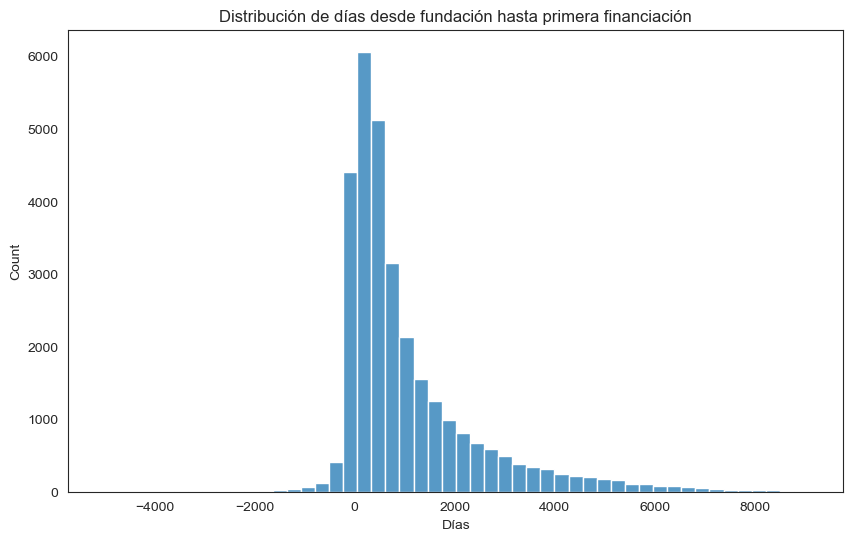

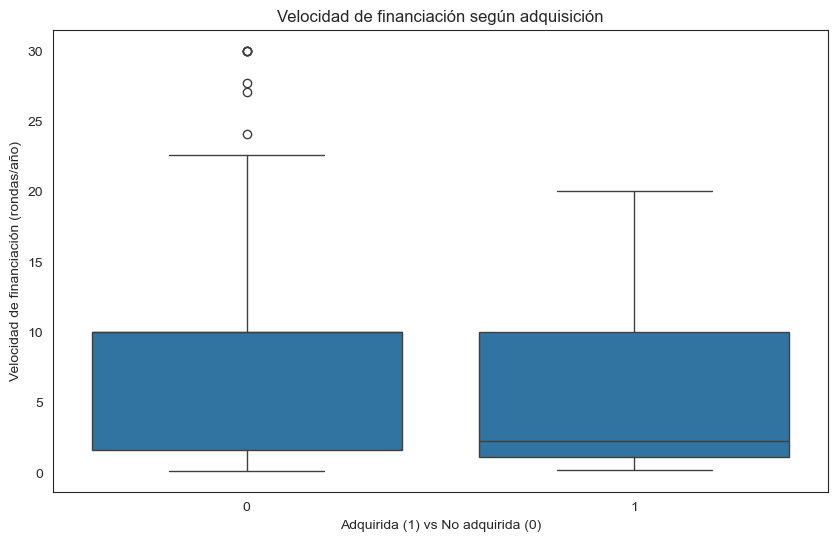

In [71]:
# Convertimos las columnas de fechas a formato datetime
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Creamos nuevas variables a partir de las fechas
# 1. Extracción de año, mes y día de la fecha de fundación
df['founded_year_dt'] = df['founded_at'].dt.year
df['founded_month'] = df['founded_at'].dt.month
df['founded_quarter'] = df['founded_at'].dt.quarter

# 2. Tiempo desde fundación hasta primera financiación (en días)
df['days_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days

# 3. Tiempo desde primera hasta última financiación (en días)
df['funding_duration_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

# 4. Velocidad de financiación (rondas por año)
df['funding_velocity'] = df['funding_rounds'] / (df['funding_duration_days'] / 365 + 0.1)  # Evitamos división por cero

# Visualizamos las nuevas variables
plt.figure(figsize=(10, 6))
sns.histplot(df['days_to_first_funding'].dropna(), bins=50)
plt.title('Distribución de días desde fundación hasta primera financiación')
plt.xlabel('Días')
plt.show()

# Comparamos la velocidad de financiación entre startups adquiridas y no adquiridas
plt.figure(figsize=(10, 6))
sns.boxplot(x='exito', y='funding_velocity', data=df)
plt.title('Velocidad de financiación según adquisición')
plt.xlabel('Adquirida (1) vs No adquirida (0)')
plt.ylabel('Velocidad de financiación (rondas/año)')
plt.show()

### 8.2 Validación

In [72]:
# 0) Detecta y convierte Interval a string en el df completo
interval_cols = df.select_dtypes(include=['interval']).columns.tolist()
if interval_cols:
    for col in interval_cols:
        df[col] = df[col].astype(str)

# 1) Genera date‐features en df (ya lo tienes)
#    … tu código …

# 2) Re-split a partir de ese df con date‐features convertidas
X = df.drop(columns=['exito'])
y = df['exito']
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 3) Asegura numéricas
for D in (X_train, X_val):
    for col in ['days_to_first_funding','funding_duration_days','funding_velocity']:
        D[col] = pd.to_numeric(D[col], errors='coerce')

# 4) Lista de columnas actualizada
numerical_cols   = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Numéricas:", numerical_cols)
print("Categóricas:", categorical_cols)

# 5) Pipelines
numeric_pipeline = Pipeline([
    ('imputer', numeric_imputers[best_numeric_imp]),
    ('scaler',  scaling_methods[best_scaling_method])
])

cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enc', categorical_encoders[best.encoding]),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,   numerical_cols),
    ('cat', cat_pipeline,       categorical_cols),
], remainder='drop')

pipe_dates = Pipeline([
    ('pre',      preprocessor),
    ('to_dense', FunctionTransformer(lambda X: X.toarray() if hasattr(X, 'toarray') else X)),
    ('clf',      KNeighborsClassifier())
])

# 6) Evaluación
scores_dates = evaluar_pipeline(
    X_val, y_val,
    pipe_dates,
    beta=0.7,
    test_size=0.2,
    random_state=42
)

print("Date‐features + StandardScaler →",
      f"F₀.₇ = {scores_dates['f_beta']:.4f},",
      f"AUC-PR = {scores_dates['AUC-PR']:.4f}")


Numéricas: ['homepage_url', 'market', 'funding_total_usd', 'funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'angel', 'grant', 'private_equity', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'days_to_first_funding', 'funding_duration_days', 'funding_velocity']
Categóricas: ['category_list', 'country_code', 'region', 'city']
Date‐features + StandardScaler → F₀.₇ = 0.0994, AUC-PR = 0.1108


## 9. Selección de variables

Ahora que hemos creado nuevas variables, vamos a utilizar técnicas de selección para identificar las más relevantes para nuestro modelo. Utilizaremos métodos basados en filtros, wrappers y análisis de correlaciones.

### 9.1 Métodos basados en filtros

Aplicamos técnicas de selección de variables basadas en filtros para identificar las variables más relevantes para la predicción de adquisiciones. Utilizaremos los métodos SelectKBest con la puntuación f_classif para evaluar la importancia de cada variable.

In [73]:
from types import SimpleNamespace
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

# 0) Construye el objeto `best` a partir de tu DataFrame de resultados:
best_row = encoding_results.iloc[0]
best = SimpleNamespace(**best_row.to_dict())
# ahora `best.encoding` es, por ejemplo, 'ordinal' o 'target'

def build_pipeline(score_func, k):
    # --- Numéricas ---
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputers[best_numeric_imp]),
        ('scaler',  scaling_methods[best_scaling_method])
    ])
    # --- Categóricas: usa directamente el pipeline de imputación+encoding ---
    cat_pipeline = categorical_imputers[best_categorical_imp]

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipeline,     categorical_cols),
    ], remainder='drop')

    return Pipeline([
        ('pre',               preprocessor),
        ('feature_selection', SelectKBest(score_func=score_func, k=k)),
        ('clf',               knn_neighbors())
    ])

# Y luego tu bucle de evaluación sin cambiar nada más:
for score_name, score_func in [('f_classif', f_classif),
                               ('mutual_info', mutual_info_classif)]:
    for k in [5, 10, 15]:
        print(f"\n--- SelectKBest con {score_name}, k={k} ---")
        pipe = build_pipeline(score_func, k)
        pipe.fit(X_train, y_train)
        scores = evaluar_pipeline(
            X_val, y_val, pipe,
            beta=0.7, test_size=0.2, random_state=42
        )
        print(f" → F₀.₇ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")



--- SelectKBest con f_classif, k=5 ---


c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 → F₀.₇ = 0.0514, AUC-PR = 0.1251

--- SelectKBest con f_classif, k=10 ---


c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 → F₀.₇ = 0.0784, AUC-PR = 0.1925

--- SelectKBest con f_classif, k=15 ---


c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


 → F₀.₇ = 0.0497, AUC-PR = 0.1654

--- SelectKBest con mutual_info, k=5 ---


c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

 → F₀.₇ = 0.0877, AUC-PR = 0.1459

--- SelectKBest con mutual_info, k=10 ---


c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

 → F₀.₇ = 0.0481, AUC-PR = 0.1316

--- SelectKBest con mutual_info, k=15 ---


c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\marti\anaconda3\envs\py311ml\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for t

 → F₀.₇ = 0.0000, AUC-PR = 0.1084


### 9.2 Métodos basados en wrappers

Ahora aplicaremos métodos basados en wrappers para seleccionar variables, específicamente la técnica Recursive Feature Elimination (RFE) que elimina iterativamente las variables menos importantes.

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    FunctionTransformer, OneHotEncoder, OrdinalEncoder
)
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# tus encoders (todos sin sparse_output donde importe)
categorical_encoders = {
    'onehot':  OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False),
    'ordinal': OrdinalEncoder(handle_unknown='use_encoded_value',
                              unknown_value=-1),
    'target':  TargetEncoder()  # asume devuelve dense
}

# helper que convierte *cualquier* CSR a numpy.ndarray
to_dense = FunctionTransformer(
    lambda X: X.toarray() if hasattr(X, "toarray") else X,
    validate=False
)

def build_rfe_pipeline(n_features, step=0.2):
    numeric_pipeline = Pipeline([
        ('imp', numeric_imputers[best_numeric_imp]),
        ('to_dense', to_dense),
        ('scaler', scaling_methods[best_scaling_method])
    ])
    cat_pipeline = Pipeline([
        # <-- Aquí:
        ('imp', categorical_imputers[best_categorical_imp]),  
        ('to_dense', to_dense),
        ('enc', categorical_encoders[best.encoding])
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline,   numerical_cols),
        ('cat', cat_pipeline,       categorical_cols),
    ], remainder='drop')

    rfe = RFE(
        estimator=LogisticRegression(solver='liblinear',
                                     max_iter=2000,
                                     random_state=42),
        n_features_to_select=n_features,
        step=step
    )

    return Pipeline([
        ('pre',      preprocessor),
        ('rfe',      rfe),
        ('knn',      KNeighborsClassifier())
    ])


def build_kbest_pipeline(score_func, k):
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputers[best_numeric_imp]),
        ('to_dense', to_dense),
        ('scaler',   scaling_methods[best.scaling_method]),
    ])
    cat_pipeline = Pipeline([
        ('imputer', numeric_imputers[best.categorical_imp]),
        ('to_dense', to_dense),
        ('encoder', categorical_encoders[best.encoding]),
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline,   numerical_cols),
        ('cat', cat_pipeline,       categorical_cols),
    ], remainder='drop')

    return Pipeline([
        ('pre',   preprocessor),
        ('kbest', SelectKBest(score_func=score_func, k=k)),
        ('knn',   KNeighborsClassifier())
    ])


# --- ejemplo de uso RFE (wrapper) ---
pipe_rfe = build_rfe_pipeline(n_features=10, step=0.2)
pipe_rfe.fit(X_train, y_train)

y_proba = pipe_rfe.predict_proba(X_val)[:,1]
y_pred  = pipe_rfe.predict(X_val)

from sklearn.metrics import fbeta_score, precision_recall_curve, auc
f0_7    = fbeta_score(y_val, y_pred, beta=0.7)
prec, rec, _ = precision_recall_curve(y_val, y_proba)
auc_pr  = auc(rec, prec)

print(f"RFE → F₀.₇ = {f0_7:.4f}, AUC-PR = {auc_pr:.4f}")


RFE → F₀.₇ = 0.0115, AUC-PR = 0.1312


## 10. Detección de ruido

In [75]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 1) Imports
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, AllKNN

# 3) Preprocesador óptimo
numeric_pipeline = SKPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler',  StandardScaler())
])
if categorical_cols:
    cat_pipeline = SKPipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipeline,     categorical_cols)
    ], remainder='drop')
else:
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols)
    ], remainder='drop')

# 4) Samplers de eliminación de ruido
noise_methods = {
    'TomekLinks': TomekLinks(sampling_strategy='all'),
    'ENN':        EditedNearestNeighbours(sampling_strategy='all', kind_sel='mode', n_neighbors=3),
    'AllKNN':     AllKNN(sampling_strategy='all', kind_sel='mode', n_neighbors=3)
}

# 5) Pipeline: primero preprocesa (→ datos numéricos), luego sampler
for name, sampler in noise_methods.items():
    pipe = ImbPipeline([
        ('pre',   preprocessor),  # transforma X a numérico
        ('noise', sampler)        # ahora puede aplicar fit_resample
    ])
    X_clean, y_clean = pipe.fit_resample(X_train, y_train)
    removed = len(y_train) - len(y_clean)
    print(f"{name}: eliminadas {removed} muestras de ruido (quedan {len(y_clean)})")


## 11. Efecto de uso de árboles de decisión

In [ ]:
# ======= 1) PREPROCESADOR (preprocessor_dt) =========================
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Todas las columnas numéricas
numerical_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
# Ninguna categórica (si tuvieras, pon los nombres en esta lista)
categorical_cols = []

numeric_pipeline = SKPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler",  StandardScaler())
])

if categorical_cols:
    cat_pipeline = SKPipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor_dt = ColumnTransformer([
        ("num", numeric_pipeline, numerical_cols),
        ("cat", cat_pipeline,     categorical_cols)
    ], remainder="drop")
else:
    preprocessor_dt = ColumnTransformer([
        ("num", numeric_pipeline, numerical_cols)
    ], remainder="drop")

# ======= 2) PIPELINE Árbol + AllKNN + SMOTE =========================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, fbeta_score, precision_recall_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer

noise   = AllKNN(sampling_strategy="all", kind_sel="mode", n_neighbors=3)
balance = SMOTE(random_state=42)

dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

pipe_dt = ImbPipeline([
    ("pre",   preprocessor_dt),   # ← ya existe
    ("noise", noise),             # limpia ruido
    ("balance", balance),         # balancea con SMOTE
    ("to_dense", FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)),
    ("clf",   dt)
])

param_grid = {
    "clf__max_depth":        [None, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__min_samples_split": [2, 5, 10]
}

scoring = {
    "F0.7":   make_scorer(fbeta_score, beta=0.7),
    "AUC-PR": "average_precision"
}

rs = RandomizedSearchCV(
        pipe_dt,
        param_distributions=param_grid,
        n_iter=30,
        scoring=scoring,
        refit="F0.7",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
     )
rs.fit(X_train, y_train)

print("Mejores parámetros:", rs.best_params_)
print("F0.7 (CV):", rs.best_score_)
print("AUC-PR (CV):", rs.cv_results_["mean_test_AUC-PR"][rs.best_index_])

# ======= 3) Ajuste de umbral en validación ==========================
best_pipe = rs.best_estimator_
y_prob    = best_pipe.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_prob)

beta = 0.7
f_scores = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec)
opt_idx  = f_scores.argmax()
opt_thr  = thr[opt_idx]

print(f"Umbral óptimo: {opt_thr:.3f} — F0.7 = {f_scores[opt_idx]:.4f}")

y_pred = (y_prob >= opt_thr).astype(int)
print(">> VALIDACIÓN")
print("F0.7   =", fbeta_score(y_val, y_pred, beta=0.7))
print("AUC-PR =", auc(rec, prec))


In [ ]:
# Comparison of Instance Selection and Sampling Methods on Startup Investments Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, precision_recall_curve, auc

# Imbalanced-learn methods
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

def run_comparison(df, sample_fraction=0.3, random_state=42):
    """
    Run comparison of instance selection and sampling methods on a given dataframe.
    Parameters:
        df: pandas DataFrame - preprocessed dataframe with features and target 'exito'
        sample_fraction: float - fraction of data to use to reduce runtime
        random_state: int - random seed for reproducibility
    """
    # Use a sample of the dataframe to reduce runtime
    df_sample = df.sample(frac=sample_fraction, random_state=random_state).reset_index(drop=True)

    # Separate features and target
    X = df_sample.drop(columns=['exito'])
    y = df_sample['exito']

    # Separate numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    # Define preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Define evaluation function
    def evaluar_pipeline(X, y, pipeline, beta=0.7, test_size=0.2, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        elif hasattr(pipeline, "decision_function"):
            y_proba = pipeline.decision_function(X_test)
        else:
            y_proba = None
        scores = {
            "f_beta": fbeta_score(y_test, y_pred, beta=beta),
        }
        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            auc_pr = auc(recall, precision)
            scores["AUC-PR"] = auc_pr
        else:
            scores["AUC-PR"] = 0
        return scores

    # Define sampling and instance selection methods to compare
    methods = {
        "RandomUnderSampler": RandomUnderSampler(sampling_strategy='auto', random_state=random_state),
        "TomekLinks": TomekLinks(sampling_strategy='auto'),
        "OneSidedSelection": OneSidedSelection(sampling_strategy='auto', random_state=random_state),
        "NeighbourhoodCleaningRule": NeighbourhoodCleaningRule(sampling_strategy='auto'),
        "RandomOverSampler": RandomOverSampler(sampling_strategy='auto', random_state=random_state),
        # "CondensedNearestNeighbour": CondensedNearestNeighbour(sampling_strategy='auto', random_state=random_state),
        # tarda muchisimo en ejecutarase por eso no lo probare
        "SMOTE": SMOTE(sampling_strategy='auto', random_state=random_state),
        "SMOTETomek": SMOTETomek(sampling_strategy='auto', random_state=random_state),
        "SMOTEENN": SMOTEENN(sampling_strategy='auto', random_state=random_state)
    }

    results = []

    for name, sampler in methods.items():
        print(f"Evaluating method: {name}")
        # Build pipeline with sampler and classifier
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', KNeighborsClassifier())
        ])
        try:
            scores = evaluar_pipeline(X, y, pipeline, beta=0.7)
            print(f"f_beta: {scores['f_beta']:.4f}, AUC-PR: {scores['AUC-PR']:.4f}")
            results.append({
                'method': name,
                'f_beta': scores['f_beta'],
                'AUC-PR': scores['AUC-PR']
            })
        except Exception as e:
            print(f"Error evaluating {name}: {e}")
            results.append({
                'method': name,
                'f_beta': None,
                'AUC-PR': None,
                'error': str(e)
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).sort_values(by=['f_beta', 'AUC-PR'], ascending=False)
    print("\nSummary of results:")
    print(results_df)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='method', y='f_beta', data=results_df)
    plt.title('Comparison of f_beta scores by method')
    plt.xticks(rotation=45)
    plt.ylabel('f_beta score')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='method', y='AUC-PR', data=results_df)
    plt.title('Comparison of AUC-PR scores by method')
    plt.xticks(rotation=45)
    plt.ylabel('AUC-PR score')
    plt.tight_layout()
    plt.show()

## 12. Muestreo de datos para problemas no balanceados

## 13. Cambio de umbrales de clasificación